# Agrupamento de Ementas Legislativas de Sorocaba-SP usando Diferentes Métodos de Extração de Características e Algoritmos de Agrupamento

Sorocaba, situada no estado de São Paulo, possui um complexo conjunto de leis municipais que abrangem uma ampla gama de tópicos. Estas leis, que regulamentam desde questões urbanísticas até políticas de saúde e educação, representam um vasto corpus textual. A análise e interpretação desse corpus é fundamental não apenas para profissionais do direito e legisladores, mas também para cidadãos que buscam compreender seus direitos e obrigações no contexto municipal.

O principal objetivo deste projeto é avaliar e comparar a eficácia de diferentes algoritmos de extração de características e de agrupamento na segmentação das leis municipais de Sorocaba com base em seu conteúdo textual. Ao fazer isso, buscamos identificar padrões e temas comuns, facilitando a análise e categorização das leis.

Neste notebook, exploramos três técnicas amplamente reconhecidas de extração de características:

* **TF-IDF (Term Frequency-Inverse Document Frequency):** Uma técnica consagrada em processamento de linguagem natural que converte textos em vetores numéricos, dando peso às palavras conforme sua frequência no documento e sua raridade no corpus completo.

* **Doc2Vec:** Um modelo que representa documentos como vetores no espaço, capturando a semântica e as relações entre as palavras no documento.

* **BERTimbau:** Uma variação do modelo BERT pré-treinado especificamente para o português brasileiro, que é capaz de converter textos em representações vetoriais densas, capturando nuances contextuais.

Para cada técnica de extração de características, aplicamos três algoritmos de agrupamento distintos:

1. **K-Means:** Uma abordagem particional que procura segmentar os dados em clusters pré-definidos, minimizando a distância intra-cluster e maximizando a distância inter-cluster.

2. **DBSCAN:** Um algoritmo que se baseia na densidade para agrupar pontos que estão próximos entre si e identificar pontos que estão isolados em regiões de baixa densidade como outliers.

3. **Hierarchical Clustering:** Uma técnica que cria uma hierarquia de clusters, representada por um dendrograma, permitindo visualizar a estrutura dos dados em diferentes níveis de granularidade.
Ao final desta série de notebooks, esperamos fornecer insights claros sobre quais combinações de algoritmos de extração de características e de agrupamento são mais eficazes para agrupar e interpretar as leis municipais de Sorocaba.

## Instalação de Bibliotecas

Para a execução deste notebook, será necessário instalar algumas bibliotecas que não são padrão na maioria dos ambientes Python. Estas incluem gensim (para Doc2Vec), transformers (para BERTimbau) e torchvision (uma dependência para alguns modelos de deep learning).

Execute os comandos abaixo para instalar as bibliotecas necessárias:

In [1]:
%pip install gensim
%pip install transformers
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Importações e Configurações Iniciais

Antes de mergulharmos na análise, vamos importar as bibliotecas necessárias e realizar algumas configurações iniciais:

- **pandas:** Utilizada para manipulação e análise de dados.
  
- **numpy:** Biblioteca para suporte de arrays e matrizes multidimensionais, juntamente com uma coleção de funções matemáticas para operar nesses arrays.

- **torch:** Biblioteca de aprendizado profundo que fornece uma plataforma flexível para construção e treinamento de modelos de aprendizado de máquina.

- **gensim:** Biblioteca usada para modelagem de tópicos e análise semântica profunda. Aqui, será usada para a implementação do Doc2Vec.

- **transformers:** Fornece arquiteturas e modelos para trabalhar com NLP, incluindo BERT e suas variantes, como o BERTimbau.

- **sklearn:** Uma das bibliotecas mais populares para machine learning em Python, usada aqui para a extração de características dos textos e para a implementação dos algoritmos de clusterização.

- **matplotlib** e **seaborn:** Usadas para criação de visualizações e gráficos.

Vamos proceder com as importações:

In [2]:
import pandas as pd
import numpy as np
import torch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Carregamento e Pré-processamento dos Dados

Primeiro, vamos carregar nossos dados e inspecionar as primeiras entradas para entender sua estrutura.

In [3]:
# Carregando os dados:
df = pd.read_csv("./data/Leis de Sorocaba (Pre-Grouped).csv").dropna()

# Obtendo todas as colunas exceto 'summary'
group_columns = [col for col in df.columns if col != 'summary']

# Filtrando as linhas que têm pelo menos um 'True' nos agrupamentos prévios:
df = df[df[group_columns].any(axis=1)]

# Removendo os valores nulos:
df = df.dropna()

# Verificando as primeiras linhas do dataframe:
df.head()

summary  \
0  dispor sobre denominação josé antonio pascoto ...   
1  dispor sobre denominação vitor hage via públic...   
2  dispor sobre denominação lisardo cunha dia via...   
3  dispor sobre denominação desirre ferraz cardos...   
4  instituir calendário oficial município dia soc...   

   leis_orcamentarias_e_creditos_adicionais  teor_tributario  \
0                                     False            False   
1                                     False            False   
2                                     False            False   
3                                     False            False   
4                                     False            False   

   titulo_de_utilidade_publica  dias_tematicos  \
0                        False           False   
1                        False           False   
2                        False           False   
3                        False           False   
4                        False            True   

   denominacoes_de_proprios_publicos  \
0                               True   
1                               True   
2                               True   
3                               True   
4                              False   

   estrutura_administracao_publica_e_servidores  titulos_honorificos  \
0                                         False                False   
1                                         False                False   
2                                         False                False   
3                                         False                False   
4                                         False                False   

   urbanismo_e_obras  normas_sobre_bancos  revogacoes  alteracoes  convenios  
0              False                False       False       False      False  
1              False                False       False       False      False  
2              False                False       False       False      False  
3              False                False       False       False      False  
4              False                False       False       False      False

In [4]:
df.shape

(9781, 13)

## Stratified Sampling

In [5]:
# Removendo duplicatas baseadas na coluna 'summary'
df_unique = df.drop_duplicates(subset='summary')

def stratified_sample(df, group_columns, n_samples=500):
    samples = []  # Lista para armazenar as amostras de cada grupo
    for group in group_columns:
        group_df = df[df[group]]  # Filtrar os exemplos do grupo atual
        # Se o grupo for menor do que o número de amostras desejado, pegue todo o grupo
        print(f'group: {group}; len: {len(group_df)}')
        if len(group_df) < n_samples:
            samples.append(group_df)
        else:
            # Caso contrário, pegue uma amostra do grupo
            samples.append(group_df.sample(n=n_samples, random_state=42))
    # Concatenar todas as amostras em um único DataFrame
    stratified_sample = pd.concat(samples).drop_duplicates(subset='summary').reset_index(drop=True)
    return stratified_sample

# Chamar a função
stratified_df = stratified_sample(df_unique, group_columns)

group: leis_orcamentarias_e_creditos_adicionais; len: 134
group: teor_tributario; len: 270
group: titulo_de_utilidade_publica; len: 837
group: dias_tematicos; len: 276
group: denominacoes_de_proprios_publicos; len: 4947
group: estrutura_administracao_publica_e_servidores; len: 652
group: titulos_honorificos; len: 17
group: urbanismo_e_obras; len: 534
group: normas_sobre_bancos; len: 14
group: revogacoes; len: 122
group: alteracoes; len: 931
group: convenios; len: 433


In [6]:
stratified_df

summary  \
0     estimar receita fixo despesa município exercíc...   
1     autorizar poder executivo abrir crédito adicio...   
2     estimar receita fixo despesa munícipio exercíc...   
3     estabelecer plano plurianual município quadriê...   
4     autorizar poder executivo utilizar todo emenda...   
...                                                 ...   
3496     autorizar celebração convênio governo estadual   
3497  dispor sobre celebração convênio secretaria es...   
3498  autorizar celebração convênio faculdade medici...   
3499  autorizar poder executivo municipal celebrar c...   
3500  autorizar prefeitura firmar convênio serviço e...   

      leis_orcamentarias_e_creditos_adicionais  teor_tributario  \
0                                         True            False   
1                                         True            False   
2                                         True            False   
3                                         True            False   
4                                         True            False   
...                                        ...              ...   
3496                                     False            False   
3497                                     False            False   
3498                                     False            False   
3499                                     False            False   
3500                                     False            False   

      titulo_de_utilidade_publica  dias_tematicos  \
0                           False           False   
1                           False           False   
2                           False           False   
3                           False           False   
4                           False           False   
...                           ...             ...   
3496                        False           False   
3497                        False           False   
3498                        False           False   
3499                        False           False   
3500                        False           False   

      denominacoes_de_proprios_publicos  \
0                                 False   
1                                 False   
2                                 False   
3                                 False   
4                                 False   
...                                 ...   
3496                              False   
3497                              False   
3498                              False   
3499                              False   
3500                              False   

      estrutura_administracao_publica_e_servidores  titulos_honorificos  \
0                                            False                False   
1                                            False                False   
2                                            False                False   
3                                            False                False   
4                                            False                False   
...                                            ...                  ...   
3496                                         False                False   
3497                                         False                False   
3498                                         False                False   
3499                                         False                False   
3500                                         False                False   

      urbanismo_e_obras  normas_sobre_bancos  revogacoes  alteracoes  \
0                 False                False       False       False   
1                 False                False       False       False   
2                 False                False       False       False   
3                 False                False       False       False   
4                 False                False       False       False   
...                 ...                  ...   

In [7]:
def count_group_occurrences(df, groups):
    count = {}
    for group_name in groups:
        count[group_name] = df[group_name].sum()
    return count

count = count_group_occurrences(stratified_df, group_columns)

for group, quantity in count.items():
    print(f"{group}: {quantity} documentos")

leis_orcamentarias_e_creditos_adicionais: 134 documentos
teor_tributario: 270 documentos
titulo_de_utilidade_publica: 507 documentos
dias_tematicos: 276 documentos
denominacoes_de_proprios_publicos: 628 documentos
estrutura_administracao_publica_e_servidores: 522 documentos
titulos_honorificos: 17 documentos
urbanismo_e_obras: 508 documentos
normas_sobre_bancos: 14 documentos
revogacoes: 122 documentos
alteracoes: 606 documentos
convenios: 433 documentos


In [8]:
df = stratified_df

In [9]:
df.shape

(3501, 13)

In [10]:
# Exibir as 30 palavras mais frequentes no corpus
def plot_30_most_frequent_words(words):
  counter = Counter(words.split())
  most_frequent = counter.most_common(30)

  # Fazer um gráfico de barras das palavras frequentes
  fig = plt.figure(1, figsize = (20,10))
  _ = pd.DataFrame(most_frequent, columns=("words","count"))
  sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
  # Adicionando os títulos
  plt.title("30 palavras mais frequentes")
  plt.xlabel("Palavra")
  plt.ylabel("Frequência")

  # Ajustando a orientação dos rótulos do eixo x
  plt.xticks(rotation=45)

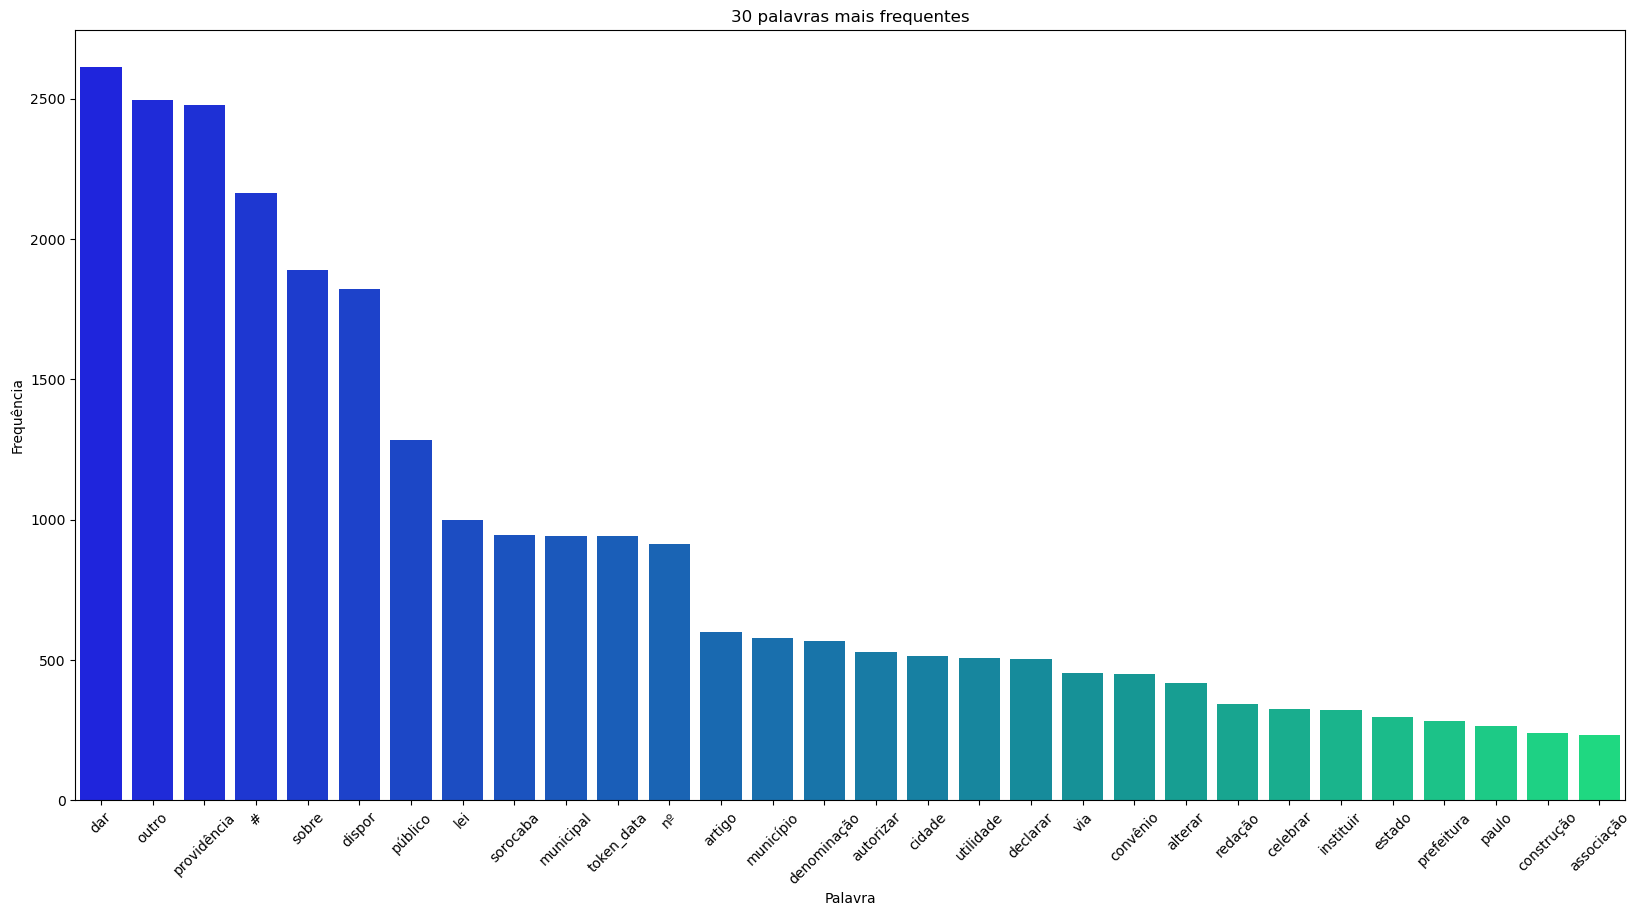

In [11]:
# Unir todas as palavras do corpus
summary_words = ' '.join(list(df['summary'].fillna('').values))

plot_30_most_frequent_words(summary_words)

Existem muitas observações com termos que não agregam valor para nossa análise. Vamos remover estes termos:

In [12]:
# Removendo termos irrelevantes:
remove_phrases = ['dispor sobre', 'dar outro providência', '#']
remove_phrases_regex = '|'.join(remove_phrases)
df['summary'] = df['summary'].str.replace(remove_phrases_regex, ' ', regex=True).str.strip()

## Extração de Características

### TF-IDF

**TF-IDF** é a abreviação de **Term Frequency-Inverse Document Frequency**. É uma técnica estatística usada para determinar a importância de uma palavra em um documento, dentro de um corpus. O valor do TF-IDF aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensado pela frequência da palavra no corpus. Isso ajuda a ajustar o fato de que algumas palavras aparecem mais frequentemente em geral.

O TF-IDF é calculado da seguinte forma:

1. **Term Frequency (TF)**: É a frequência relativa de uma palavra em um documento em relação ao total de palavras no mesmo documento. É calculado como:

$$
TF(t) = \frac{\text{Número de vezes que o termo t aparece no documento}}{\text{Número total de termos no documento}}
$$

2. **Inverse Document Frequency (IDF)**: É o logaritmo da razão total de documentos pelo número de documentos contendo o termo. O IDF diminui o peso de palavras que ocorrem muito frequentemente nos documentos e aumenta o peso de palavras que ocorrem raramente. É calculado como:

$$
IDF(t) = \log \frac{\text{Número total de documentos}}{\text{Número de documentos com o termo t}}
$$

Portanto, o TF-IDF é o produto de TF e IDF:

$$
TFIDF(t) = TF(t) \times IDF(t)
$$

#### Principais Parâmetros

Quando usamos o TF-IDF em bibliotecas como o `sklearn`, existem vários parâmetros que podemos ajustar:

1. **max_features**: Define o número máximo de termos que devem ser retidos. É útil quando estamos lidando com textos muito extensos, pois podemos limitar o número de características a serem consideradas, mantendo apenas os termos mais relevantes.

2. **stop_words**: São palavras que são filtradas antes ou depois do processamento do texto. Palavras comuns como "e", "é", "de", entre outras, que não contêm informações significativas, são geralmente removidas.

3. **max_df**: Ignora os termos que aparecem em mais do que uma fração especificada dos documentos. Por exemplo, se definido como 0.85, ele ignorará termos que aparecem em mais de 85% dos documentos.

4. **min_df**: Semelhante ao `max_df`, mas nesse caso, ele ignora os termos que aparecem em menos do que uma fração especificada dos documentos.

5. **ngram_range**: Define o intervalo de n-grams a serem extraídos. Por exemplo, se definido como (1, 2), ele extrairá unigrams e bigrams.

#### Importância para o Desempenho

Ajustar os parâmetros do TF-IDF é crucial para obter uma boa representação dos textos. Uma representação inadequada pode prejudicar o desempenho dos algoritmos de clusterização. Por exemplo:

- **Removendo palavras irrelevantes**: Usar `stop_words` e ajustar `max_df` e `min_df` pode ajudar a remover termos que são muito comuns ou muito raros, respectivamente. Esses termos muitas vezes não agregam valor significativo à análise.

- **Considerando bigrams ou trigrams**: Às vezes, a combinação de palavras pode ter um significado diferente do das palavras individuais. Por exemplo, "alta" e "pressão" podem não ser muito informativas individualmente, mas juntas, como "alta pressão", podem ser muito relevantes.

- **Limitando o número de características**: Em grandes conjuntos de dados, a dimensão do espaço de características pode se tornar muito alta, o que pode prejudicar o desempenho de certos algoritmos devido à "maldição da dimensionalidade". Limitar o número de características usando `max_features` pode ajudar a mitigar esse problema.

#### Análise da Frequência dos Termos

Antes de proceder com a clusterização, é crucial compreender a distribuição dos termos em nosso corpus. Isso nos permite fazer ajustes informados, melhorando a qualidade da representação textual e, consequentemente, os resultados da clusterização.

In [13]:
# Usando CountVectorizer para obter a frequência de documentos de cada termo
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(df['summary'])

# Calculando a frequência de documentos para cada termo
df_freq = np.sum(X_count > 0, axis=0)
df_freq = np.squeeze(np.asarray(df_freq))

In [14]:
words_less_than_5 = np.sum(df_freq < 5)
print(f"Número de palavras com 5 ou menos ocorrências: {words_less_than_5}")

words_more_than_5 = np.sum(df_freq >= 5)
print(f"Número de palavras com 5 ou mais ocorrências: {words_more_than_5}")

Número de palavras com 5 ou menos ocorrências: 3412
Número de palavras com 5 ou mais ocorrências: 855


In [15]:
# Encontrar índices das palavras que aparecem menos de 5 vezes
word_indices = np.where((df_freq < 5))[0]

# Mapear índices para palavras
words = np.array(vectorizer.get_feature_names_out())[word_indices]

print(words)

['aai' 'abaac' 'abaas' ... 'ônibus' 'último' 'únicoo']


In [16]:
from nltk.tokenize import word_tokenize
# Crie um conjunto para armazenar palavras únicas
unique_words = set()

# Adicione cada palavra única ao conjunto
for doc in df['summary']:
    words = word_tokenize(doc)
    unique_words.update(words)

print(f'Tamanho do vocabulário: {len(unique_words)}')

# Tokenize cada documento e conte o número total de palavras
total_words = 0
for doc in df['summary']:
    words = word_tokenize(doc)
    total_words += len(words)

print(f'Total de palavras no corpus: {total_words}')

Tamanho do vocabulário: 4337
Total de palavras no corpus: 36673


##### Histograma da Frequência dos Termos

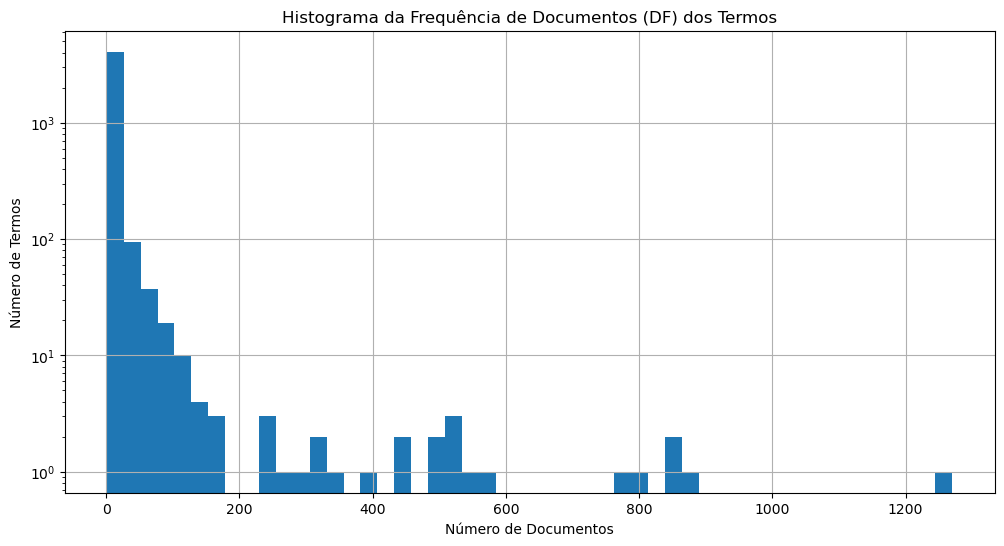

In [17]:
# Plotando o histograma da frequência de documentos
plt.figure(figsize=(12, 6))
plt.hist(df_freq, bins=50, log=True)  # Usamos escala logarítmica no eixo y para melhor visualização
plt.title("Histograma da Frequência de Documentos (DF) dos Termos")
plt.xlabel("Número de Documentos")
plt.ylabel("Número de Termos")
plt.grid(True)
plt.show()

##### Histograma Log-Log da Frequência de Documentos (DF) dos Termos

O segundo histograma, em uma escala log-log, mostra a distribuição das frequências de documentos para os termos em nosso corpus. A frequência de documentos de um termo é o número de documentos diferentes em que esse termo aparece.

A observação da distribuição nos informa:

* Há mais de mil ($10^3$) termos que aparecem em apenas um documento ($10^0$), indicando a presença de termos muito específicos ou possivelmente ruidosos.

* Aproximadamente 100 ($10^2$) termos aparecem em 10 documentos ($10^1$), sugerindo termos que ainda são relativamente raros.

* Mais de 10 ($10^1$) termos ocorrem em 100 documentos ($10^2$), representando termos mais comuns.

* A partir de 1000 ($10^3$) documentos em diante, vemos que a maioria dos termos está concentrada em torno de 1 ($10^0$), indicando que poucos termos são extremamente comuns no corpus.

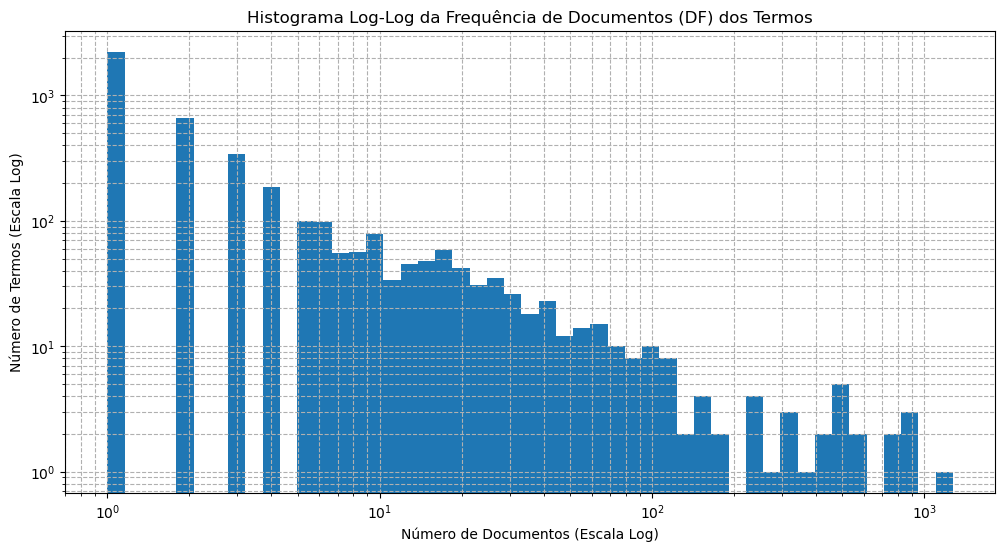

In [18]:
plt.figure(figsize=(12, 6))
plt.hist(df_freq, bins=np.logspace(np.log10(1), np.log10(df_freq.max()+1), 50), log=True)
plt.yscale("log")
plt.title("Histograma Log-Log da Frequência de Documentos (DF) dos Termos")
plt.xlabel("Número de Documentos (Escala Log)")
plt.ylabel("Número de Termos (Escala Log)")
plt.xscale("log")
plt.grid(True, which="both", ls="--")
plt.show()

##### Conclusão
Com base na análise acima:

* **Estimativa de `min_df`:** Dado o grande número de termos que aparecem em apenas um documento, consideraríamos ajustar o min_df para um valor maior que 1. Um valor inicial como 5 ou 10 poderia ser considerado, com o objetivo de filtrar termos que aparecem em menos de 5 ou 10 documentos, respectivamente. Podemos também utilizar um valor percentual do total de documentos, como 0.01 ou 0.05.

* **Estimativa de `max_df`:** Devido à presença de termos extremamente comuns que aparecem em muitos documentos (por exemplo, em mais de $10^3$ documentos), podemos considerar ajustar o max_df para filtrar tais termos. Um valor como 0.7 ou 0.8 do total de documentos pode ser uma boa escolha inicial.

Estas são recomendações iniciais e, como sempre, a experimentação com diferentes valores e a avaliação dos clusters resultantes nos fornecerá uma visão mais clara sobre as melhores configurações.

#### Implementação do TF-IDF

Nesta seção, transformaremos nossos textos brutos em representações numéricas usando o TF-IDF. A configuração escolhida para o vetorizador é baseada em nossa análise exploratória anterior:

- **max_features=1000**: Limitamos a representação a 1000 características (termos) para manter apenas os termos mais relevantes.

- **stop_words=None**: Não aplicamos a remoção de stopwords neste passo, pois já tratamos disso anteriormente.

- **ngram_range=(1, 3)**: Além de termos individuais (unigrams), também consideramos combinações de até 3 palavras (trigrams) para capturar contextos mais amplos.

- **max_df=0.80**: Ignoramos termos que aparecem em mais de 80% dos documentos, pois são muito comuns e podem não ser discriminativos.

- **min_df=10**: Ignoramos termos que aparecem em menos de 10 documentos para filtrar raridades ou ruídos.

Ao final desta transformação, cada documento será representado por um vetor numérico, onde cada valor indica a importância relativa de um termo no documento em relação ao corpus como um todo.

In [19]:
vectorizer = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 3),
    max_df=0.8,
    min_df=5
    )
X_tfidf = vectorizer.fit_transform(df['summary'])


In [20]:
X_tfidf.shape

(3501, 300)

### Doc2Vec

**Doc2Vec**, também conhecido como **Paragraph2Vec** ou **Sentence Embeddings**, é uma extensão do modelo Word2Vec para documentos ou sequências de palavras maiores do que um único termo. Enquanto o Word2Vec gera uma representação vetorial para cada palavra no vocabulário, o Doc2Vec gera uma representação vetorial para cada documento no corpus.

A ideia por trás do Doc2Vec é representar um documento como uma combinação de:

1. Um vetor que representa o próprio documento.

2. Vetores para palavras individuais no documento.

Os vetores são aprendidos de forma que representações semelhantes de palavras e documentos estejam próximas no espaço vetorial.

#### Principais Parâmetros

Quando usamos o Doc2Vec em bibliotecas como `gensim`, existem vários parâmetros que podemos ajustar:

1. **vector_size**: Define o número de dimensões do vetor de saída.

2. **window**: Máximo de distância entre a palavra atual e as palavras previstas dentro de uma sentença.

3. **min_count**: Ignora todas as palavras com frequência total inferior a este.

4. **workers**: Número de núcleos do CPU a serem usados para treinar o modelo.

5. **epochs**: Número de iterações (épocas) sobre o corpus.

#### Importância para o Desempenho

Ajustar os parâmetros do Doc2Vec é fundamental para obter representações de alta qualidade dos documentos:


- **Tamanho do vetor**: Escolher um tamanho de vetor adequado é crucial. Tamanhos muito pequenos podem não capturar toda a informação, enquanto tamanhos muito grandes podem levar a overfitting.

- **Janela**: Uma janela maior pode capturar mais contexto, mas também pode incluir informações menos relevantes.

- **Frequência mínima de palavras**: Filtrar palavras raras pode ajudar a focar nas palavras mais informativas.

#### Implementação do Doc2Vec

Para representar nossos documentos usando Doc2Vec, precisamos seguir alguns passos:

1. **Preparar os dados**: Cada documento deve ser tokenizado (dividido em palavras) e associado a uma etiqueta única. No nosso caso, estamos usando o índice do documento como etiqueta, o que garante a unicidade. As etiquetas são úteis não só durante o treinamento, mas também quando queremos inferir vetores para novos documentos.

In [21]:
# Preparando os dados
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['summary'].apply(lambda x: x.split(" ")))]

2. **Treinar o modelo Doc2Vec nos dados preparados**: Uma vez que os dados estão formatados corretamente, procedemos com o treinamento do modelo Doc2Vec. Durante esse processo, o modelo tenta aprender representações vetoriais para os documentos de tal forma que o contexto das palavras dentro dos documentos seja preservado.

   - **vector_size=100**: Escolhemos uma representação de tamanho 100 para cada documento. Isso é uma escolha intermediária e geralmente funciona bem para muitos datasets. Valores típicos para vector_size variam de 50 a 300. Uma representação de maior dimensão poderia capturar mais nuances, mas também pode levar a maior complexidade e risco de sobreajuste.
   
   - **window=5**: O tamanho da janela de contexto foi definido como 5, o que significa que, para cada palavra, o modelo considerará 5 palavras anteriores e 5 palavras subsequentes como contexto. Valores comuns para window estão na faixa de 5 a 10.
   
   - **min_count=5**: Ignoramos palavras que aparecem em menos de 5 documentos. Esse parâmetro ajuda a filtrar palavras raras ou específicas demais que poderiam não ser úteis para a representação geral.
   
   - **workers=4**: Número de núcleos de CPU usados para treinar o modelo. Isso é específico para otimizar o tempo de treinamento.
   
   - **epochs=100**: Número de iterações sobre o corpus durante o treinamento. Um número maior de épocas pode permitir que o modelo aprenda melhor, mas também corre o risco de sobreajuste se for muito alto.

In [22]:
# Treinando o modelo Doc2Vec
model = Doc2Vec(vector_size=100, window=5, min_count=5, workers=4, seed=42, epochs=20)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)


3. **Obter a representação vetorial para cada documento**: Após o treinamento, o modelo tem a capacidade de representar cada documento como um vetor no espaço que aprendeu. Usamos o método `infer_vector` para obter essas representações para cada um dos nossos documentos. Esses vetores são o que usaremos para as análises subsequentes e agrupamento.

In [23]:
# Obtendo a representação vetorial para cada documento
X_doc2vec = np.array([model.infer_vector(doc.words) for doc in documents])

In [24]:
X_doc2vec.shape

(3501, 100)

### BERTimbau

**BERTimbau** é uma adaptação do modelo BERT (Bidirectional Encoder Representations from Transformers) pré-treinado especificamente para o português. O BERT é uma arquitetura de Processamento de Linguagem Natural (PLN) que utiliza transformers e atenção para entender o contexto das palavras em um texto. Ao contrário dos modelos anteriores, como Word2Vec ou Doc2Vec, que aprendem representações para palavras ou documentos individualmente, o BERT é capaz de considerar o contexto completo de uma palavra em uma frase, tornando-o especialmente poderoso para tarefas de compreensão de texto.

#### Principais Parâmetros

Ao utilizar o BERTimbau ou qualquer variante do BERT, existem vários parâmetros e considerações a serem observados:

1. **Modelo pré-treinado**: O BERT é geralmente pré-treinado em um grande corpus e depois adaptado (fine-tuned) para tarefas específicas. O BERTimbau é uma dessas variantes pré-treinadas, otimizada para o português.
2. **Tamanho do tokenizador**: BERT utiliza um tokenizador que pode quebrar palavras em subpalavras ou caracteres, permitindo uma cobertura efetiva de um vasto vocabulário com um tamanho de modelo menor.
3. **Camadas e tamanho do modelo**: Existem diferentes tamanhos de BERT disponíveis, variando em termos de número de camadas e tamanho do modelo. Modelos maiores geralmente oferecem melhor desempenho, mas são mais computacionalmente intensivos.
4. **Sequência máxima de comprimento**: BERT tem uma limitação de comprimento de sequência (geralmente 512 tokens). Textos mais longos precisam ser truncados ou divididos.

#### Importância para o Desempenho

A adaptação correta do BERT para sua tarefa específica é fundamental para aproveitar ao máximo o poder deste modelo:

- **Fine-tuning**: Embora o BERTimbau seja pré-treinado, adaptar o modelo aos seus dados específicos (fine-tuning) pode melhorar significativamente o desempenho.
- **Comprimento da Sequência**: A limitação de comprimento do BERT significa que a escolha de como lidar com documentos longos (truncando, dividindo ou combinando) pode impactar o desempenho.
- **Uso de camadas**: O BERT tem várias camadas, e diferentes camadas capturam diferentes tipos de informações. Experimentar com saídas de diferentes camadas pode ser benéfico dependendo da tarefa.

#### Implementação do BERTimbau

Para representar nossos documentos usando BERTimbau:

1. **Carregamento do Tokenizador e Modelo:** Carregamos o tokenizador e o modelo específico do BERTimbau, que serão usados para processar e extrair características dos textos.

In [24]:
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-large-portuguese-cased")
model = BertModel.from_pretrained("neuralmind/bert-large-portuguese-cased")

2. **Definição da Função de Extração:** Criamos uma função chamada extract_embedding que realiza a tokenização do texto e, em seguida, o alimenta através do modelo BERTimbau para obter a representação vetorial.

In [25]:
def extract_embedding(text):
    input_ids = tokenizer.encode(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(input_ids)
    # Pega apenas o embedding do token [CLS], que é o primeiro token
    cls_embedding = outputs['last_hidden_state'][0, 0].numpy()
    return cls_embedding

In [26]:
extract_embedding('Ideias e somente ideias podem iluminar a escuridão')

array([-0.18656069,  0.14431599, -0.1004325 , ...,  0.8591389 ,
       -0.31845835,  0.6330984 ], dtype=float32)

3. **Aplicação da Função e Obtenção das Representações:** Usamos a função `extract_embedding` para processar cada texto do dataframe. O resultado é uma lista de vetores que representam os textos.

In [27]:
X_bertimbau = np.array([extract_embedding(text) for text in df['summary']])

In [28]:
X_bertimbau.shape

(3501, 1024)

In [29]:
np.save('./models/X_bertimbau-large.npy', X_bertimbau)

In [25]:
X_bertimbau = np.load('./models/X_bertimbau-large.npy')

## Normalização

In [26]:
from sklearn.preprocessing import StandardScaler

# Para a normalização MinMax
scaler = StandardScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf.toarray())
X_doc2vec_scaled = scaler.fit_transform(X_doc2vec)
X_bertimbau_scaled = scaler.fit_transform(X_bertimbau)

# X_tfidf_scaled = X_tfidf.toarray()
# X_doc2vec_scaled = X_doc2vec
# X_bertimbau_scaled = X_bertimbau

## Redução de Dimensionalidade

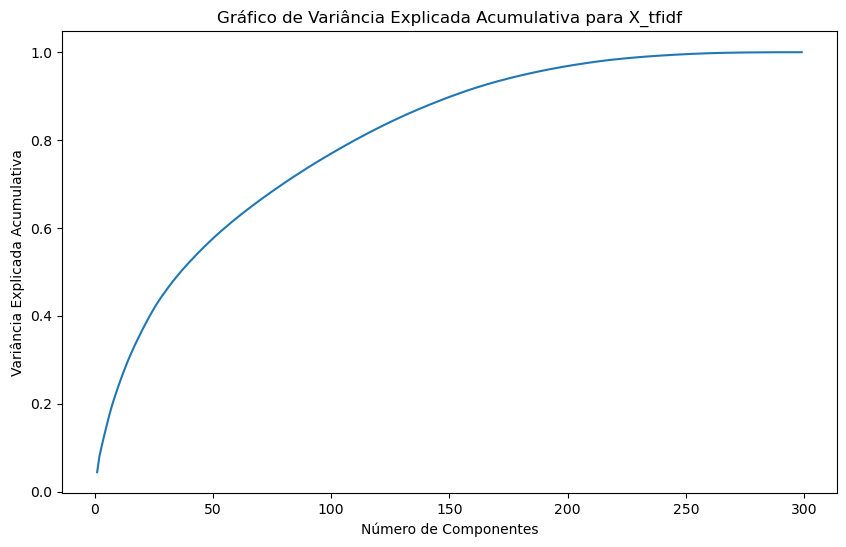

In [27]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Passo 1: Aplicar o SVD truncado
svd = TruncatedSVD(n_components=299)
X_tfidf_svd = svd.fit_transform(X_tfidf_scaled)

# Passo 2: Calcular a variância explicada acumulativa
var_exp_cumul = np.cumsum(svd.explained_variance_ratio_)

# Passo 3: Plote o gráfico
plt.figure(figsize=(10,6))
plt.plot(range(1, 300), var_exp_cumul)
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulativa')
plt.title('Gráfico de Variância Explicada Acumulativa para X_tfidf')
plt.show()

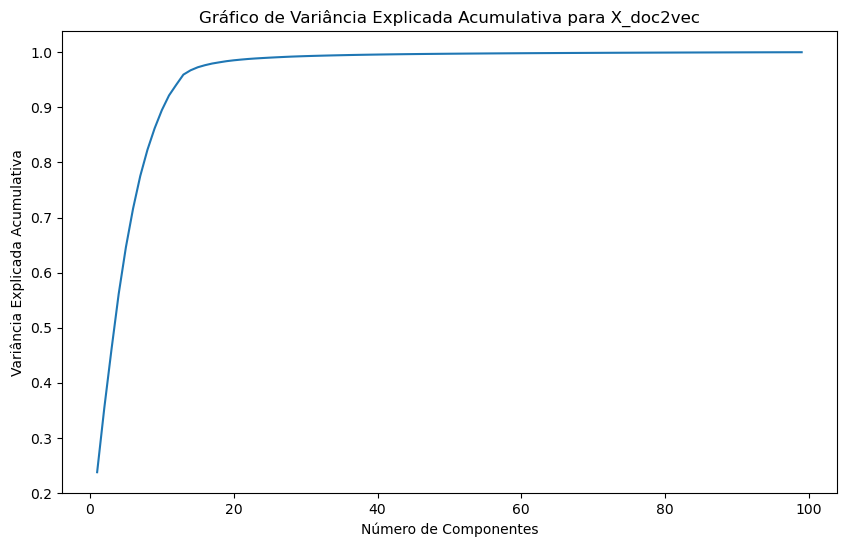

In [28]:
# Passo 1: Aplicar o SVD truncado
svd = TruncatedSVD(n_components=99)
X_doc2vec_svd = svd.fit_transform(X_doc2vec_scaled)

# Passo 2: Calcular a variância explicada acumulativa
var_exp_cumul = np.cumsum(svd.explained_variance_ratio_)

# Passo 3: Plote o gráfico
plt.figure(figsize=(10,6))
plt.plot(range(1, 100), var_exp_cumul)
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulativa')
plt.title('Gráfico de Variância Explicada Acumulativa para X_doc2vec')
plt.show()

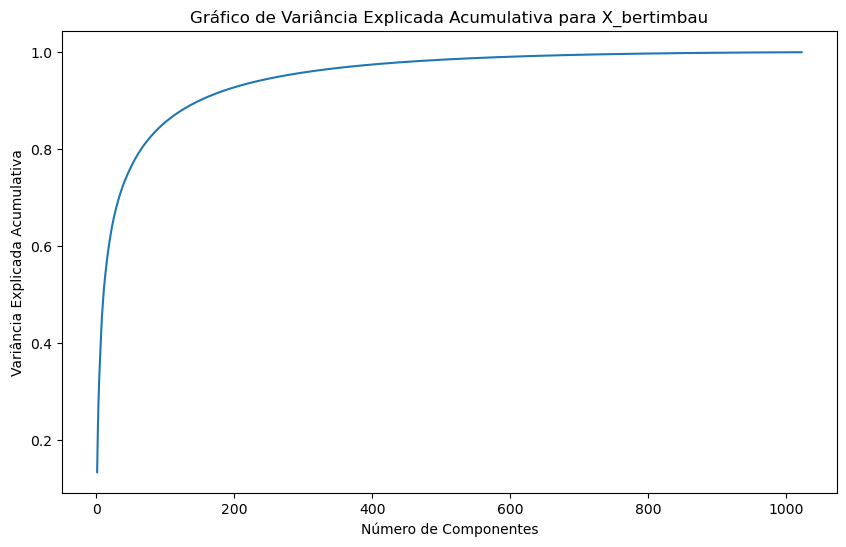

In [29]:
# Passo 1: Aplicar o SVD truncado
svd = TruncatedSVD(n_components=1023)
X_bertimbau_svd = svd.fit_transform(X_bertimbau_scaled)

# Passo 2: Calcular a variância explicada acumulativa
var_exp_cumul = np.cumsum(svd.explained_variance_ratio_)

# Passo 3: Plote o gráfico
plt.figure(figsize=(10,6))
plt.plot(range(1, 1024), var_exp_cumul)
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulativa')
plt.title('Gráfico de Variância Explicada Acumulativa para X_bertimbau')
plt.show()

In [30]:
# Cria o objeto SVD com 150 componentes
svd = TruncatedSVD(n_components=150)

# Ajusta o SVD ao seus dados e reduz as dimensões
X_tfidf_scaled = svd.fit_transform(X_tfidf_scaled)

# Verifica o formato do novo conjunto de dados
print(X_tfidf_scaled.shape)

(3501, 150)


In [31]:
# Cria o objeto SVD com 20 componentes
svd = TruncatedSVD(n_components=20)

# Ajusta o SVD ao seus dados e reduz as dimensões
X_doc2vec_scaled = svd.fit_transform(X_doc2vec_scaled)

# Verifica o formato do novo conjunto de dados
print(X_doc2vec_scaled.shape)

(3501, 20)


In [32]:
# Cria o objeto SVD com 200 componentes
svd = TruncatedSVD(n_components=200)

# Ajusta o SVD ao seus dados e reduz as dimensões
X_bertimbau_scaled = svd.fit_transform(X_bertimbau_scaled)

# Verifica o formato do novo conjunto de dados
print(X_bertimbau_scaled.shape)

(3501, 200)


## Clusterização

### K-Means

O K-Means é um dos algoritmos de agrupamento mais populares e é categorizado como particional. O objetivo do algoritmo é dividir um conjunto de pontos em `K` grupos (ou clusters) de densidade semelhante. O "K" em K-Means refere-se ao número de clusters que o algoritmo tentará identificar.

O funcionamento do algoritmo é iterativo:

1. **Inicialização:** Escolha `K` pontos do conjunto de dados como os centroides iniciais dos clusters.

2. **Atribuição:** Atribua cada ponto ao centróide mais próximo, formando `K` clusters.

3. **Recálculo:** Calcule o ponto médio (centróide) de cada cluster.

4. **Repetição:** Repita os passos 2 e 3 até que os centroides não mudem significativamente ou até que um número máximo de iterações seja alcançado.

Uma das decisões mais cruciais ao usar K-Means é a escolha do valor de `K`, ou seja, o número de clusters a serem formados.

#### Escolhendo o valor de `K` - Método do Cotovelo

Uma das técnicas mais comuns para determinar o número ótimo de clusters é o método do cotovelo. O método envolve executar a clusterização K-Means no conjunto de dados para um intervalo de valores de `K` (por exemplo, `K` de 1 a 10), e para cada valor de `K`, a inércia (ou soma dos erros quadráticos dentro dos clusters) é calculada. Essas inércias são então plotadas em um gráfico.

O "cotovelo" do gráfico representa um ponto de inflexão onde a taxa de diminuição da inércia se estabiliza, indicando que adicionar mais clusters não resultará em uma melhoria significativa do ajuste. O valor de `K` no "cotovelo" é considerado um bom indicador do número ótimo de clusters.

Entretanto, a escolha do número de clusters não é apenas uma questão técnica. A interpretabilidade dos clusters, a experiência de domínio e outros fatores contextuais também devem ser considerados ao tomar a decisão.

In [33]:
def plot_elbow_method(X, extractor_name):
    """
    Função para plotar o método do cotovelo para determinar o K ótimo.
    
    Parâmetros:
    X: Matriz de características.
    extractor_name: Nome do método de extração de características (e.g., "TF-IDF", "Doc2Vec", "BERTimbau").
    """
    inertia = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=42).fit(X)
        inertia.append(kmeans.inertia_)
        
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 15), inertia)
    plt.xlabel('Número de clusters')
    plt.ylabel('Inércia')
    plt.title(f'Método do cotovelo para K ótimo no {extractor_name}')
    plt.show()

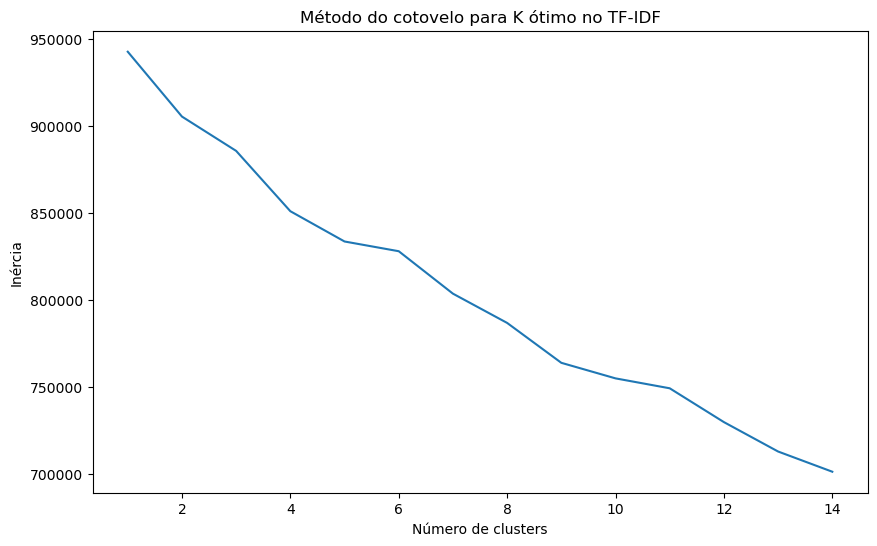

In [34]:
plot_elbow_method(X_tfidf_scaled, "TF-IDF")

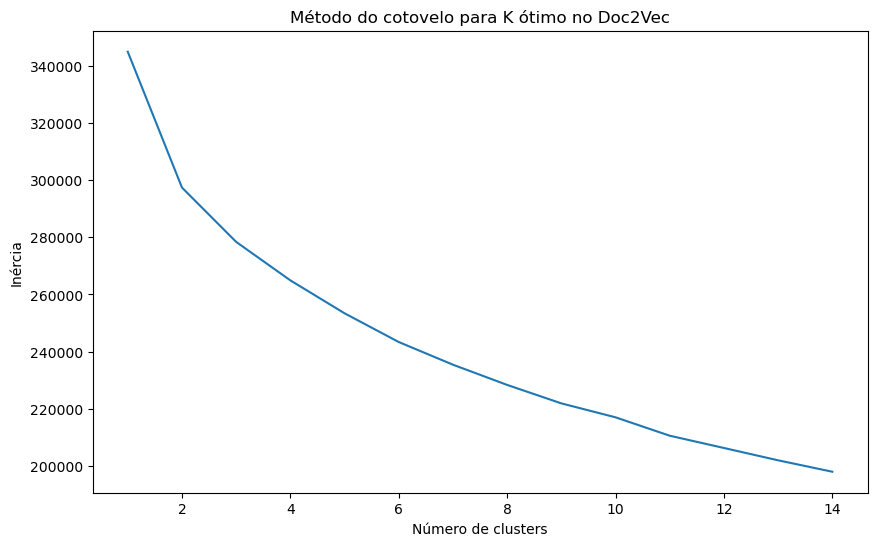

In [35]:
plot_elbow_method(X_doc2vec_scaled, "Doc2Vec")

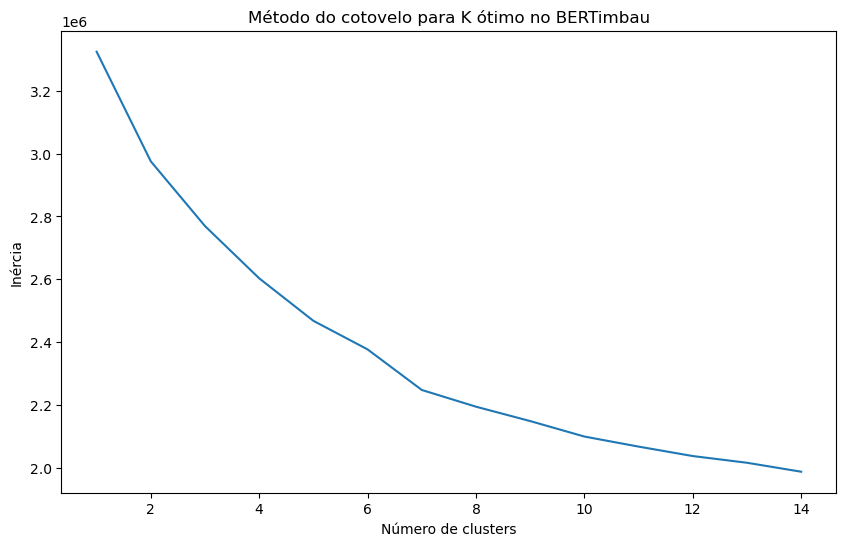

In [36]:
plot_elbow_method(X_bertimbau_scaled, "BERTimbau")

#### Escolha do Valor de `K` Baseado no Domínio do Problema

Em cenários onde técnicas quantitativas não fornecem um indicador claro para o número ideal de clusters (como acima), o conhecimento do domínio se torna uma ferramenta inestimável. 

No contexto da clusterização de leis municipais, tal conhecimento é especialmente crucial, dada a natureza complexa e multifacetada dos textos legais. Assim, usamos uma categorização fornecida por um especialista no domínio, que sugere agrupar as leis por temas específicos.

Os agrupamentos detalhados estão disponíveis no documento anexo `Grupos temáticos de legislação`. Com base neles, identificamos 11 temas principais:

1. Leis Orçamentárias e Créditos Adicionais

2. Título de Utilidade Pública

3. Teor Tributário

4. Dias Temáticos

5. Denominações de Próprios Públicos

6. Estrutura da Administração Pública e Servidores Públicos

7. Títulos Honoríficos

8. Urbanismo e Obras

9. Revogações

10. Normas sobre Bancos

11. Alterações de Artigos

12. Convênios

Portanto, poderíamos escolher `K = 12` para a clusterização, alinhando as leis diretamente com os agrupamentos temáticos. Essa decisão garante que a segmentação seja relevante, significativa e matematicamente coerente com os objetivos da análise.

Entretanto, nosso conjunto de leis pode não ter representantes para todos os grupos. Assim, é necessário que avaliemos a quantidade real de grupos. Vamos verificar a existência das palavras chave definidas em nosso anexo.


In [37]:
NUM_CLUSTERS = 12

# Para o TF-IDF
kmeans_tfidf = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X_tfidf_scaled)
df['kmeans_labels_tfidf'] = kmeans_tfidf.labels_

# Para o Doc2Vec
kmeans_doc2vec = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X_doc2vec_scaled)
df['kmeans_labels_doc2vec'] = kmeans_doc2vec.labels_

# Para o BERTimbau
kmeans_bertimbau = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X_bertimbau_scaled)
df['kmeans_labels_bertimbau'] = kmeans_bertimbau.labels_

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### DBSCAN

O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clusterização baseado em densidade que pode identificar clusters de forma e tamanho variáveis. Ao contrário de métodos centróides como o K-means, que são sensíveis à forma dos clusters, o DBSCAN trabalha identificando regiões densas no espaço de dados.

#### Principais características e vantagens do DBSCAN:

1. **Densidade:** Ao invés de agrupar com base na distância média de pontos a um centróide, o DBSCAN identifica clusters como regiões de alta densidade separadas por regiões de baixa densidade.

2. **Número de Clusters:** Não requer a especificação do número de clusters a priori. Ele determina o número de clusters com base nos dados e nos parâmetros fornecidos.

3. **Ruído:** É capaz de identificar e tratar pontos de ruído, ou seja, observações que não pertencem a nenhum cluster.

4. **Forma Variável:** Pode identificar clusters de formas e tamanhos variáveis, tornando-o particularmente útil para conjuntos de dados com agrupamentos de forma irregular.

#### Parâmetros principais:

* **eps:** Define a distância máxima entre duas amostras para que uma seja considerada na vizinhança da outra. Um valor pequeno pode resultar em muitos pequenos clusters, enquanto um valor muito grande pode resultar em união de clusters distintos.

* **min_samples:** O número mínimo de amostras (ou peso total) em uma vizinhança para um ponto de dados ser considerado como núcleo. Isso inclui o próprio ponto.

Uma das principais considerações ao usar o DBSCAN é a escolha adequada de eps e min_samples. Uma má escolha desses parâmetros pode levar a resultados subótimos de clusterização.

#### Estimativa do Parâmetro `eps` usando a Distância do k-ésimo Vizinho Mais Próximo

Uma das principais dificuldades ao usar o algoritmo DBSCAN é determinar um valor adequado para o parâmetro epsilon (ou eps). Uma técnica comum para estimar esse valor é utilizar a distância do k-ésimo vizinho mais próximo.

##### O processo funciona da seguinte maneira:

1. Para cada ponto, calcule a distância até o k-ésimo vizinho mais próximo (neste exemplo, k=50).

2. Ordene estas distâncias em ordem crescente.

3. Plote as distâncias.

O ponto de inflexão máximo neste gráfico, muitas vezes referido como "cotovelo", é uma boa indicação do valor de epsilon a ser usado. Em outras palavras, é o ponto onde um aumento na distância do k-ésimo vizinho mais próximo começa a mostrar taxas de crescimento mais acentuadas, indicando a distância entre pontos de dados em clusters densos e pontos de dados em regiões de baixa densidade ou ruído.

##### No código fornecido:

* Utilizamos o NearestNeighbors do scikit-learn para encontrar os k-vizinhos mais próximos de cada ponto.
* As distâncias são então ordenadas e plotadas para visualização.

Ao examinar o gráfico resultante, você deve buscar o ponto onde a curva começa a subir rapidamente. Este ponto representa uma boa estimativa para o valor de epsilon.

In [303]:
def plot_knn_distances(X, extractor_name, k=10):
    """
    Função para plotar as distâncias do k-ésimo vizinho mais próximo.
    
    Parâmetros:
    X: Matriz de características.
    extractor_name: Nome do método de extração de características (e.g., "TF-IDF", "Doc2Vec", "BERTimbau").
    k: k-ésimo vizinho. Valor padrão é 5.
    """
    # Inicializando o modelo NearestNeighbors com k vizinhos
    nearest_neighbors = NearestNeighbors(n_neighbors=k)

    # Ajustando o modelo aos dados
    nearest_neighbors.fit(X)

    # Obtendo as distâncias e índices dos k vizinhos mais próximos de cada ponto
    distances, indices = nearest_neighbors.kneighbors(X)

    # Ordenando as distâncias para cada ponto
    distances = np.sort(distances, axis=0)

    # Selecionando as distâncias do k-ésimo vizinho mais próximo
    distances = distances[:,1]

    # Plotando as distâncias ordenadas
    plt.figure(figsize=(10,6))
    plt.plot(distances)
    plt.title(f'Distâncias para o {k}º Vizinho Mais Próximo no {extractor_name}')
    plt.xlabel('Pontos ordenados')
    plt.ylabel(f'Distância para o {k}º vizinho mais próximo')
    plt.show()

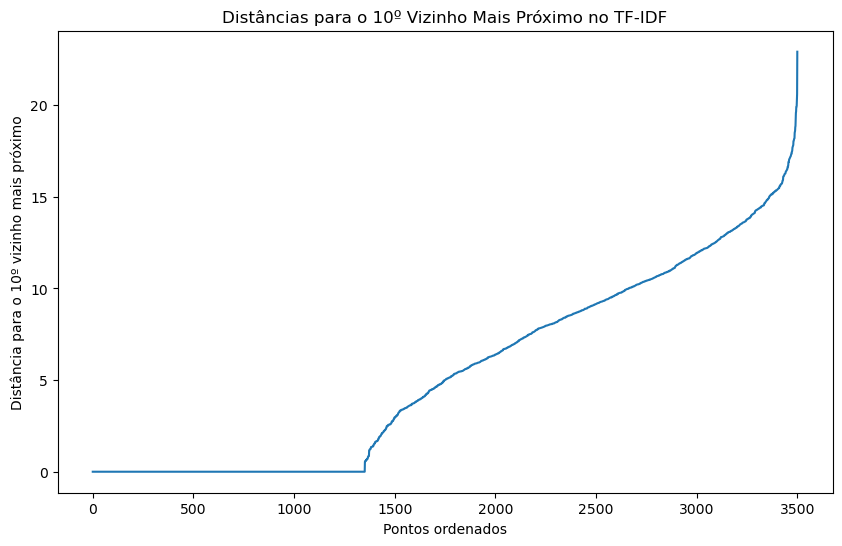

In [304]:
plot_knn_distances(X_tfidf_scaled, "TF-IDF")

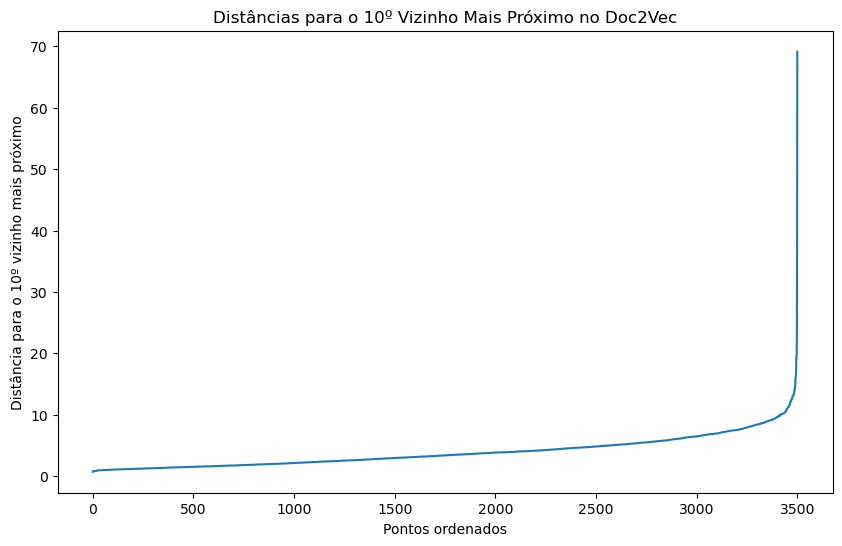

In [305]:
plot_knn_distances(X_doc2vec_scaled, "Doc2Vec")

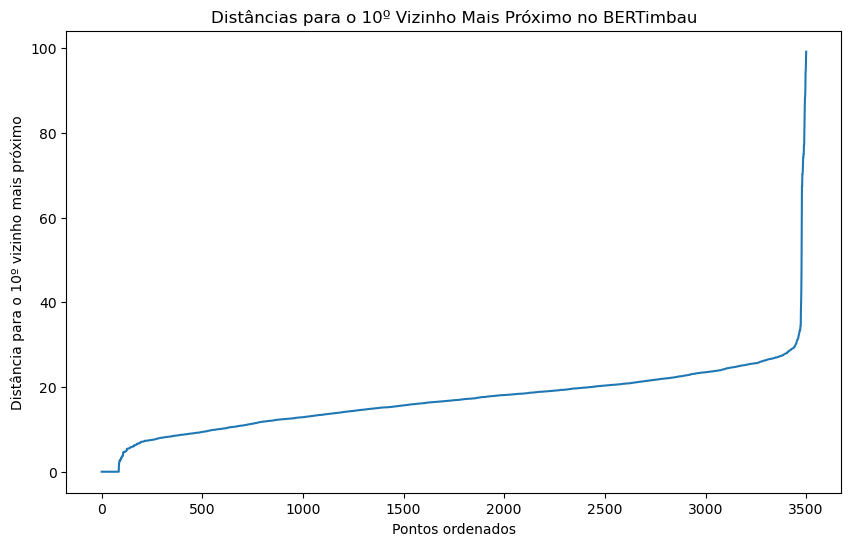

In [306]:
plot_knn_distances(X_bertimbau_scaled, "BERTimbau")

In [427]:
# Para o TF-IDF
dbscan_tfidf = DBSCAN(eps=13.5, min_samples=10).fit(X_tfidf_scaled)
df['dbscan_labels_tfidf'] = dbscan_tfidf.labels_

# Para o Doc2Vec
dbscan_doc2vec = DBSCAN(eps=6.5, min_samples=10).fit(X_doc2vec_scaled)
df['dbscan_labels_doc2vec'] = dbscan_doc2vec.labels_

# Para o BERTimbau
dbscan_bertimbau = DBSCAN(eps=18, min_samples=10).fit(X_bertimbau_scaled)
df['dbscan_labels_bertimbau'] = dbscan_bertimbau.labels_

### Hierarchical Clustering

O Hierarchical Clustering, ou Agrupamento Hierárquico, é uma abordagem de clusterização que busca construir uma hierarquia de clusters. Ao contrário do K-means ou DBSCAN, que são algoritmos de partição, o agrupamento hierárquico cria uma árvore de clusters, também conhecida como dendrograma.

#### Características principais:

1. **Hierarquia**: Cria uma série de clusters aninhados, permitindo uma visualização em diferentes níveis de granularidade.

2. **Não exige especificação de número de clusters**: Ao observar o dendrograma, você pode decidir o número de clusters cortando a árvore em um nível específico.

3. **Determinístico**: Diferentemente do K-means, que pode fornecer diferentes resultados em execuções diferentes, o agrupamento hierárquico é determinístico.

#### Métodos de ligação (ou aglomeração):

- **Single Linkage**: O cluster é definido pela menor distância entre dois pontos em diferentes clusters.

- **Complete Linkage**: A distância entre clusters é definida pela maior distância entre dois pontos em diferentes clusters.

- **Average Linkage**: A distância entre clusters é a média das distâncias entre os pontos nos dois clusters.

- **Ward's Method**: Busca minimizar a variância dentro do cluster.

#### Processo básico:

1. **Inicialização**: Cada ponto é considerado como um cluster individual.

2. **Aglomeração**: Na etapa seguinte, os dois clusters mais próximos são combinados em um único cluster.

3. **Iteração**: O processo é repetido até que todos os pontos estejam em um único cluster.

4. **Resultado**: O resultado é uma árvore que mostra a sequência em que os clusters foram combinados e a distância entre eles naquela etapa.

Ao usar o agrupamento hierárquico, é essencial decidir o método de ligação e a métrica de distância. A escolha destes parâmetros pode influenciar significativamente a forma e o conteúdo dos clusters resultantes.

In [428]:
# Para o TF-IDF
agg_tfidf = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward').fit(X_tfidf_scaled)
df['agg_labels_tfidf'] = agg_tfidf.labels_

# Para o Doc2Vec
agg_doc2vec = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward').fit(X_doc2vec_scaled)
df['agg_labels_doc2vec'] = agg_doc2vec.labels_

# Para o BERTimbau
agg_bertimbau = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward').fit(X_bertimbau_scaled)
df['agg_labels_bertimbau'] = agg_bertimbau.labels_

## Métricas e Avaliação

Uma vez que os clusters são formados, é essencial avaliar sua qualidade. A avaliação nos permite entender o quão bem nosso algoritmo performou e também ajuda na comparação de diferentes métodos ou configurações de clusterização. Usaremos várias métricas para avaliar a coesão e separação dos clusters.

### Silhouette Score

Mede o quão similar é um objeto ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Os valores variam entre -1 e 1, onde um valor alto indica que o objeto está bem pareado com seu próprio cluster e mal pareado com clusters vizinhos.

In [429]:
# Métricas para TF-IDF
silhouette_kmeans_tfidf = silhouette_score(X_tfidf_scaled, df['kmeans_labels_tfidf'])
silhouette_dbscan_tfidf = silhouette_score(X_tfidf_scaled, df['dbscan_labels_tfidf'])
silhouette_agg_tfidf = silhouette_score(X_tfidf_scaled, df['agg_labels_tfidf'])

print(f"Silhouette Score for KMeans TF-IDF: {silhouette_kmeans_tfidf}")
print(f"Silhouette Score for DBSCAN TF-IDF: {silhouette_dbscan_tfidf}")
print(f"Silhouette Score for Hierarchical Clustering TF-IDF: {silhouette_agg_tfidf}")

# Métricas para Doc2Vec
silhouette_kmeans_doc2vec = silhouette_score(X_doc2vec_scaled, df['kmeans_labels_doc2vec'])
silhouette_dbscan_doc2vec = silhouette_score(X_doc2vec_scaled, df['dbscan_labels_doc2vec'])
silhouette_agg_doc2vec = silhouette_score(X_doc2vec_scaled, df['agg_labels_doc2vec'])

print(f"Silhouette Score for KMeans Doc2Vec: {silhouette_kmeans_doc2vec}")
print(f"Silhouette Score for DBSCAN Doc2Vec: {silhouette_dbscan_doc2vec}")
print(f"Silhouette Score for Hierarchical Clustering Doc2Vec: {silhouette_agg_doc2vec}")

# Métricas para BERTimbau
silhouette_kmeans_bertimbau = silhouette_score(X_bertimbau_scaled, df['kmeans_labels_bertimbau'])
silhouette_dbscan_bertimbau = silhouette_score(X_bertimbau_scaled, df['dbscan_labels_bertimbau'])
silhouette_agg_bertimbau = silhouette_score(X_bertimbau_scaled, df['agg_labels_bertimbau'])

print(f"Silhouette Score for KMeans BERTimbau: {silhouette_kmeans_bertimbau}")
print(f"Silhouette Score for DBSCAN BERTimbau: {silhouette_dbscan_bertimbau}")
print(f"Silhouette Score for Hierarchical Clustering BERTimbau: {silhouette_agg_bertimbau}")

Silhouette Score for KMeans TF-IDF: 0.051005218626102265
Silhouette Score for DBSCAN TF-IDF: 0.11280991549617993
Silhouette Score for Hierarchical Clustering TF-IDF: 0.02843128989546045
Silhouette Score for KMeans Doc2Vec: 0.062001895159482956
Silhouette Score for DBSCAN Doc2Vec: 0.3111077547073364
Silhouette Score for Hierarchical Clustering Doc2Vec: 0.031017286702990532
Silhouette Score for KMeans BERTimbau: 0.12792982161045074
Silhouette Score for DBSCAN BERTimbau: -0.03601059317588806
Silhouette Score for Hierarchical Clustering BERTimbau: 0.10814179480075836


### Davies-Bouldin Index

É uma métrica que indica a média da "similaridade" entre cada cluster e o cluster mais similar. A similaridade é uma medida que compara a distância entre clusters com o tamanho dos clusters em si. Valores mais baixos indicam melhores configurações de clusterização.

In [430]:
# Métricas para TF-IDF
db_kmeans_tfidf = davies_bouldin_score(X_tfidf_scaled, df['kmeans_labels_tfidf'])
db_dbscan_tfidf = davies_bouldin_score(X_tfidf_scaled, df['dbscan_labels_tfidf'])
db_agg_tfidf = davies_bouldin_score(X_tfidf_scaled, df['agg_labels_tfidf'])

print(f"Davies-Bouldin Index for KMeans TF-IDF: {db_kmeans_tfidf}")
print(f"Davies-Bouldin Index for DBSCAN TF-IDF: {db_dbscan_tfidf}")
print(f"Davies-Bouldin Index for Hierarchical Clustering TF-IDF: {db_agg_tfidf}")

# Métricas para Doc2Vec
db_kmeans_doc2vec = davies_bouldin_score(X_doc2vec_scaled, df['kmeans_labels_doc2vec'])
db_dbscan_doc2vec = davies_bouldin_score(X_doc2vec_scaled, df['dbscan_labels_doc2vec'])
db_agg_doc2vec = davies_bouldin_score(X_doc2vec_scaled, df['agg_labels_doc2vec'])

print(f"Davies-Bouldin Index for KMeans Doc2Vec: {db_kmeans_doc2vec}")
print(f"Davies-Bouldin Index for DBSCAN Doc2Vec: {db_dbscan_doc2vec}")
print(f"Davies-Bouldin Index for Hierarchical Clustering Doc2Vec: {db_agg_doc2vec}")

# Métricas para BERTimbau
db_kmeans_bertimbau = davies_bouldin_score(X_bertimbau_scaled, df['kmeans_labels_bertimbau'])
db_dbscan_bertimbau = davies_bouldin_score(X_bertimbau_scaled, df['dbscan_labels_bertimbau'])
db_agg_bertimbau = davies_bouldin_score(X_bertimbau_scaled, df['agg_labels_bertimbau'])

print(f"Davies-Bouldin Index for KMeans BERTimbau: {db_kmeans_bertimbau}")
print(f"Davies-Bouldin Index for DBSCAN BERTimbau: {db_dbscan_bertimbau}")
print(f"Davies-Bouldin Index for Hierarchical Clustering BERTimbau: {db_agg_bertimbau}")

Davies-Bouldin Index for KMeans TF-IDF: 2.3269806215166944
Davies-Bouldin Index for DBSCAN TF-IDF: 2.317048105080815
Davies-Bouldin Index for Hierarchical Clustering TF-IDF: 2.4102590931384373
Davies-Bouldin Index for KMeans Doc2Vec: 1.8341649169870202
Davies-Bouldin Index for DBSCAN Doc2Vec: 5.316600859800424
Davies-Bouldin Index for Hierarchical Clustering Doc2Vec: 2.1414646524696828
Davies-Bouldin Index for KMeans BERTimbau: 2.5155311941797547
Davies-Bouldin Index for DBSCAN BERTimbau: 1.9343935128860241
Davies-Bouldin Index for Hierarchical Clustering BERTimbau: 2.6229639609047015


### Tabela de Métricas

In [431]:
data = {
    "Metric": ["Silhouette Score", "Davies-Bouldin Index"],
    "TF-IDF KMeans": [silhouette_kmeans_tfidf, db_kmeans_tfidf],
    "TF-IDF DBSCAN": [silhouette_dbscan_tfidf, db_dbscan_tfidf],
    "TF-IDF Hierarchical": [silhouette_agg_tfidf, db_agg_tfidf],
    "Doc2Vec KMeans": [silhouette_kmeans_doc2vec, db_kmeans_doc2vec],
    "Doc2Vec DBSCAN": [silhouette_dbscan_doc2vec, db_dbscan_doc2vec],
    "Doc2Vec Hierarchical": [silhouette_agg_doc2vec, db_agg_doc2vec],
    "BERTimbau KMeans": [silhouette_kmeans_bertimbau, db_kmeans_bertimbau],
    "BERTimbau DBSCAN": [silhouette_dbscan_bertimbau, db_dbscan_bertimbau],
    "BERTimbau Hierarchical": [silhouette_agg_bertimbau, db_agg_bertimbau]
}

df_metrics = pd.DataFrame(data)
display(df_metrics)

Metric  TF-IDF KMeans  TF-IDF DBSCAN  TF-IDF Hierarchical  \
0      Silhouette Score       0.051005       0.112810             0.028431   
1  Davies-Bouldin Index       2.326981       2.317048             2.410259   

   Doc2Vec KMeans  Doc2Vec DBSCAN  Doc2Vec Hierarchical  BERTimbau KMeans  \
0        0.062002        0.311108              0.031017          0.127930   
1        1.834165        5.316601              2.141465          2.515531   

   BERTimbau DBSCAN  BERTimbau Hierarchical  
0         -0.036011                0.108142  
1          1.934394                2.622964

### Gráficos de Métricas

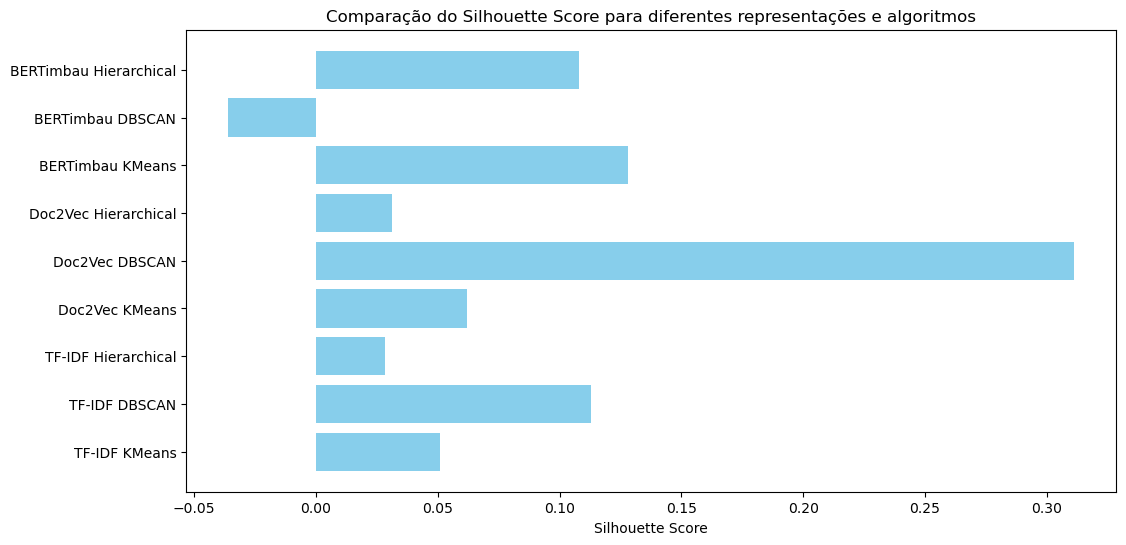

In [432]:
# Para o Silhouette Score
# Etiquetas para os diferentes métodos e algoritmos
labels = ["TF-IDF KMeans", 
          "TF-IDF DBSCAN", 
          "TF-IDF Hierarchical", 
          "Doc2Vec KMeans",
          "Doc2Vec DBSCAN", 
          "Doc2Vec Hierarchical", 
          "BERTimbau KMeans",
          "BERTimbau DBSCAN", 
          "BERTimbau Hierarchical"]

# Valores de Silhouette Score para cada combinação
scores = [silhouette_kmeans_tfidf, 
          silhouette_dbscan_tfidf,
          silhouette_agg_tfidf, 
          silhouette_kmeans_doc2vec, 
          silhouette_dbscan_doc2vec, 
          silhouette_agg_doc2vec,
          silhouette_kmeans_bertimbau,
          silhouette_dbscan_bertimbau, 
          silhouette_agg_bertimbau]

# Criação do gráfico
plt.figure(figsize=(12, 6))
plt.barh(labels, scores, color='skyblue')
plt.xlabel('Silhouette Score')
plt.title('Comparação do Silhouette Score para diferentes representações e algoritmos')
plt.show()

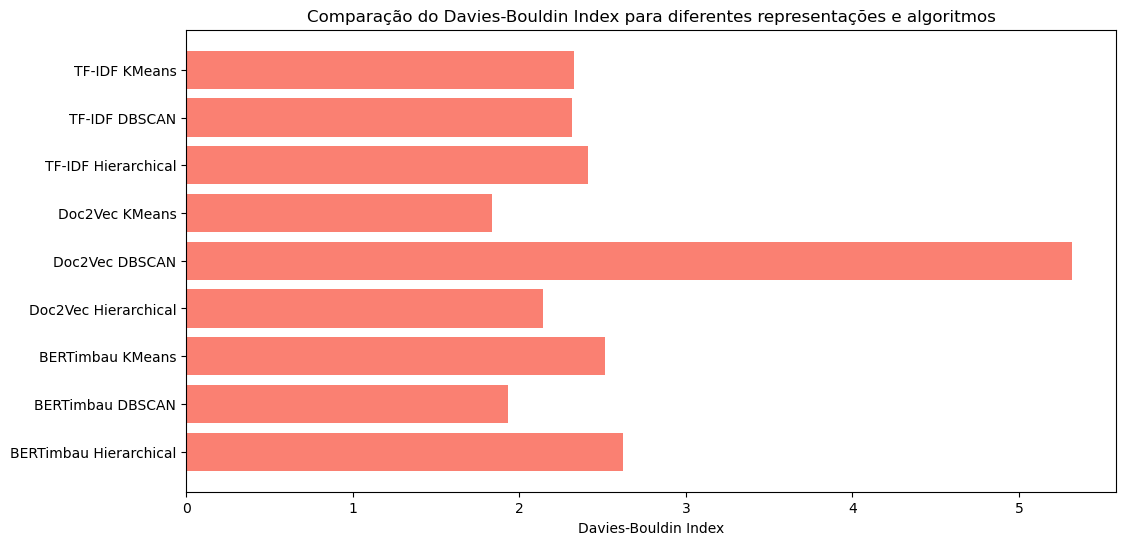

In [433]:
# Para o Davies-Bouldin Index
# Etiquetas para os diferentes métodos e algoritmos
labels = ["TF-IDF KMeans", 
          "TF-IDF DBSCAN",
          "TF-IDF Hierarchical", 
          "Doc2Vec KMeans", 
          "Doc2Vec DBSCAN", 
          "Doc2Vec Hierarchical", 
          "BERTimbau KMeans",
          "BERTimbau DBSCAN", 
          "BERTimbau Hierarchical"]

# Valores de Davies-Bouldin para cada combinação
scores_db = [db_kmeans_tfidf,
            db_dbscan_tfidf, 
            db_agg_tfidf, 
            db_kmeans_doc2vec, 
            db_dbscan_doc2vec,
            db_agg_doc2vec,
            db_kmeans_bertimbau,
            db_dbscan_bertimbau,
            db_agg_bertimbau]

# Criação do gráfico
plt.figure(figsize=(12, 6))
plt.barh(labels, scores_db, color='salmon')
plt.xlabel('Davies-Bouldin Index')
plt.title('Comparação do Davies-Bouldin Index para diferentes representações e algoritmos')
plt.gca().invert_yaxis()  # Para os valores mais baixos (melhores) aparecerem no topo
plt.show()

## Análise Qualitativa

A Análise Qualitativa se refere à avaliação não-numérica dos clusters formados. Enquanto as métricas quantitativas (como Silhouette Score e Davies-Bouldin Index) fornecem uma medida objetiva da qualidade dos clusters, a análise qualitativa permite uma interpretação mais subjetiva e contextualizada.

Nesta seção, faremos uma análise é estruturada em três partes: visualização dos clusters, distribuição dos clusters e análise de exemplos representativos de cada cluster.

Ao revisar manualmente os clusters, podemos validar se os resultados fazem sentido no contexto das leis municipais e se estão alinhados com as expectativas e o conhecimento do domínio.

### Visualização dos Clusters

A visualização de clusters em um espaço bidimensional nos permite ter uma intuição sobre como os clusters estão distribuídos e se há uma separação clara entre eles. Uma das técnicas mais populares para essa visualização é o t-SNE (t-Distributed Stochastic Neighbor Embedding). O t-SNE é uma técnica de redução de dimensionalidade que é particularmente adequada para a visualização de conjuntos de dados de alta dimensão.

In [434]:
def compute_tsne(X_list):
    tsne_results = []
    for X in X_list:
        tsne = TSNE(n_components=2, random_state=42, init="random")
        X_tsne = tsne.fit_transform(X)
        tsne_results.append(X_tsne)
    return tsne_results

In [435]:
def plot_tsne_grid(tsne_results, labels_list, titles_list):
    # Configurações do gráfico
    plt.figure(figsize=(18, 18))
    
    # Para cada combinação de características e rótulos
    for i, (X_tsne, labels, title) in enumerate(zip(tsne_results, labels_list, titles_list)):
        # Preparando o DataFrame para visualização
        df_tsne = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
        df_tsne['Cluster'] = labels

        # Plotando o gráfico correspondente
        plt.subplot(3, 3, i+1)
        sns.scatterplot(x="Dim1", y="Dim2", hue="Cluster", data=df_tsne, palette="tab10", legend="full", alpha=0.6)
        plt.title(title)

    plt.tight_layout()
    plt.show()

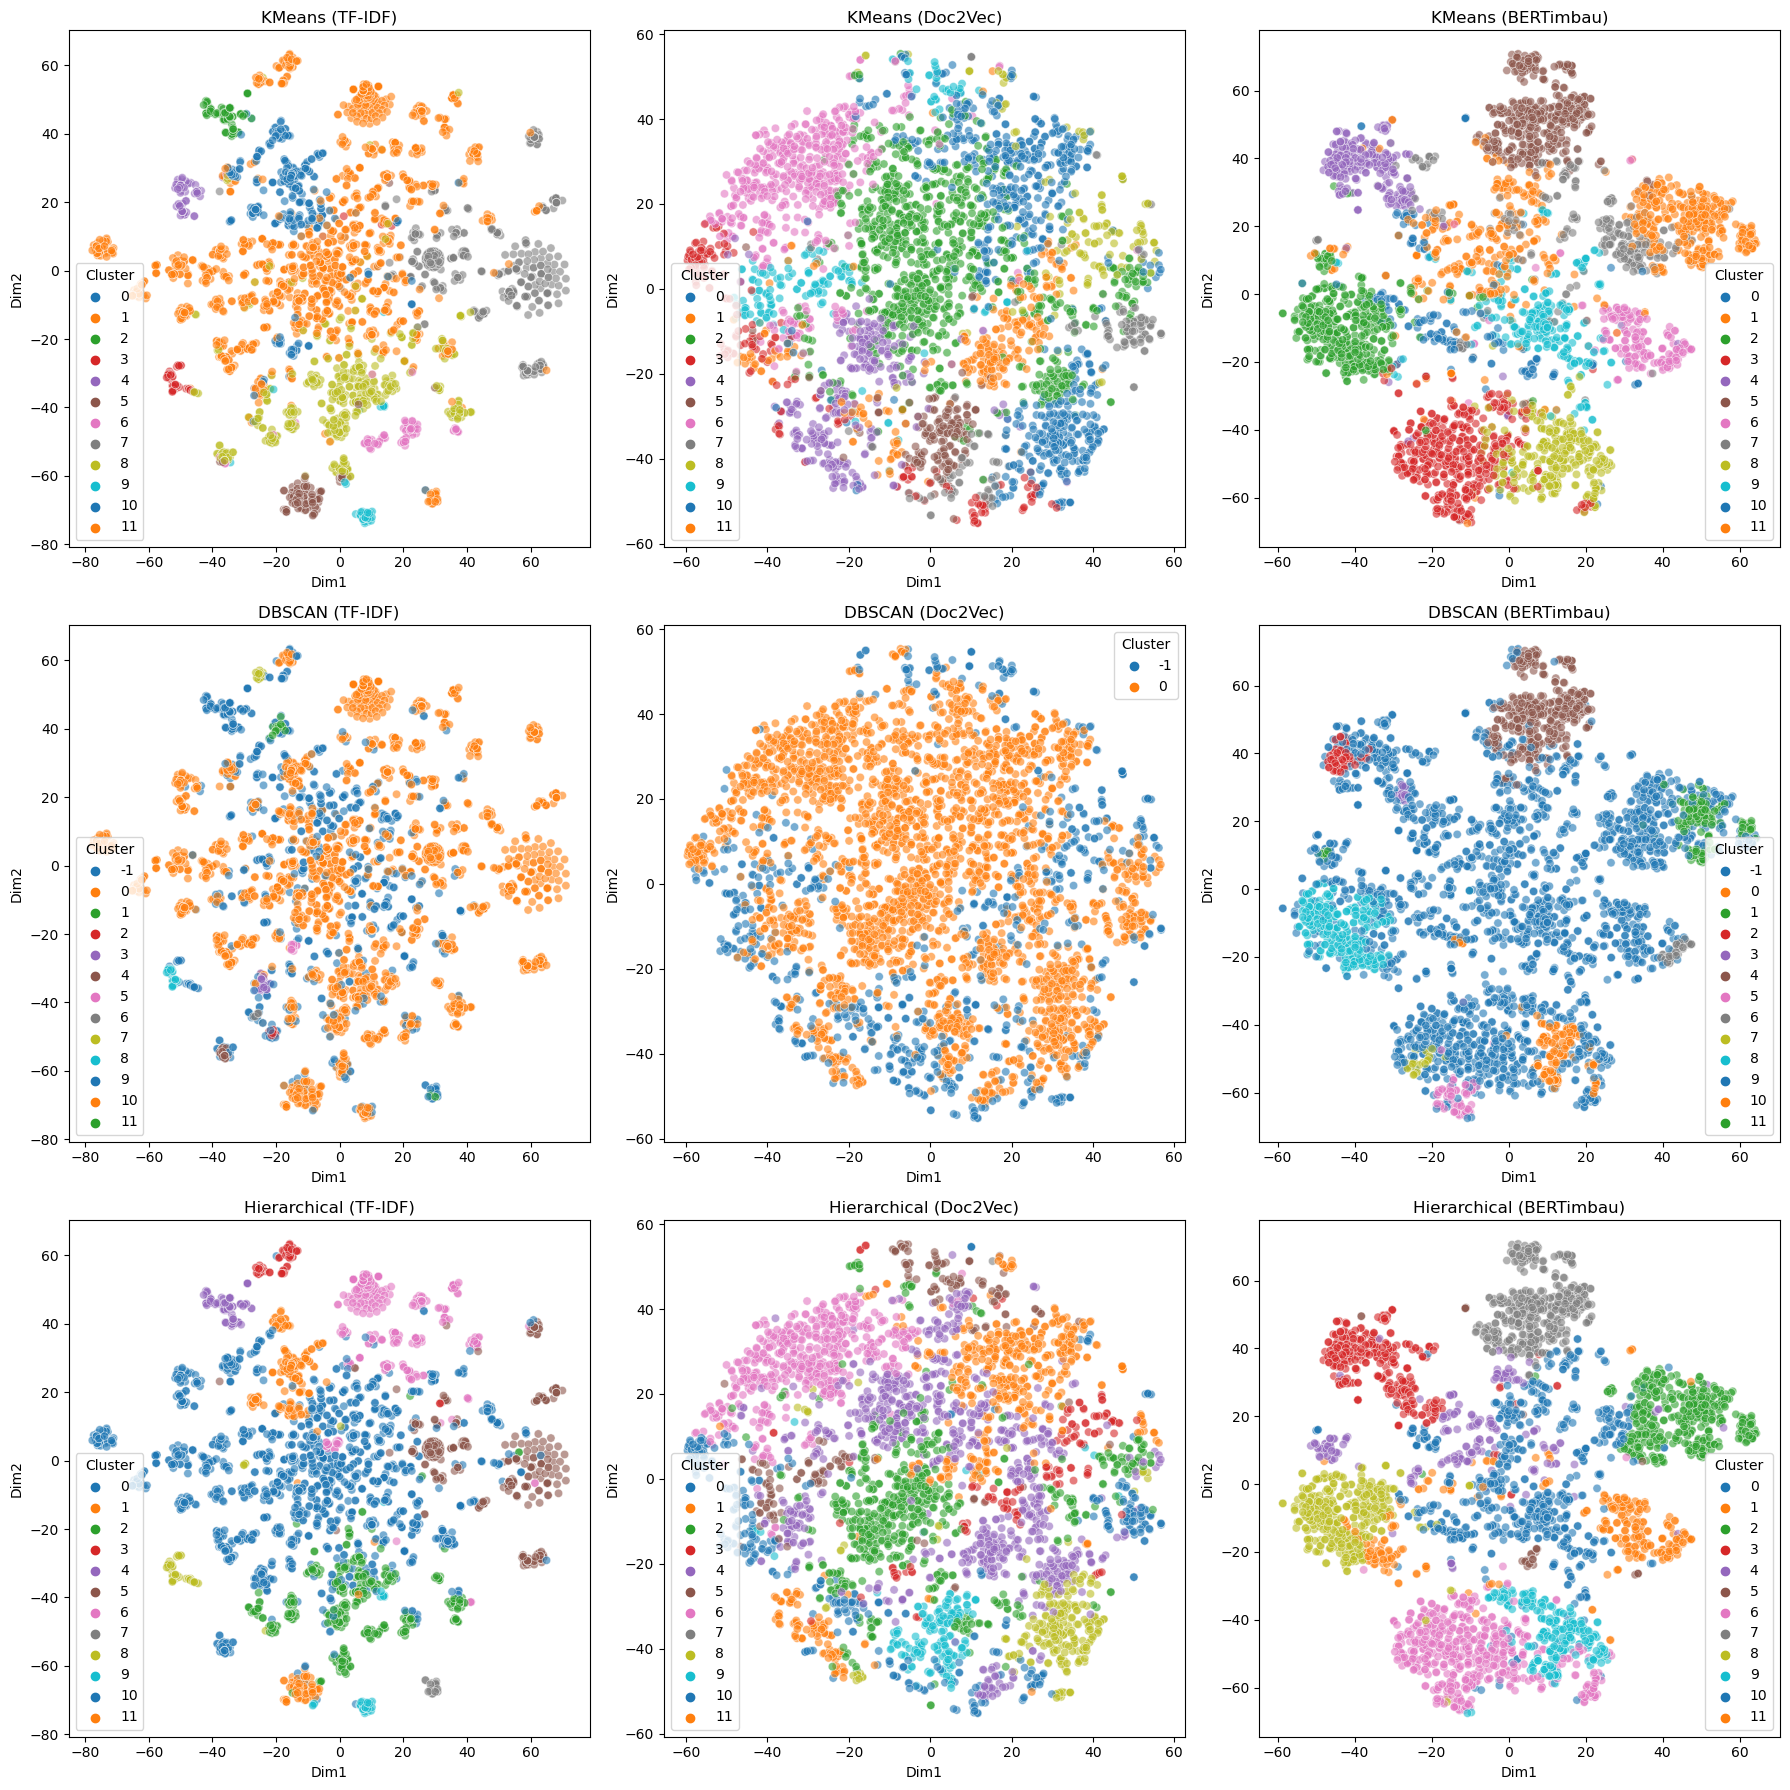

In [436]:
tsne_results = compute_tsne([X_tfidf_scaled, X_doc2vec_scaled, X_bertimbau_scaled])

# Replicando os resultados do t-SNE para cada algoritmo de clusterização
tsne_results_full = tsne_results * 3

labels_list = [
    df['kmeans_labels_tfidf'], 
    df['kmeans_labels_doc2vec'],
    df['kmeans_labels_bertimbau'],
    df['dbscan_labels_tfidf'],  
    df['dbscan_labels_doc2vec'],
    df['dbscan_labels_bertimbau'],
    df['agg_labels_tfidf'], 
    df['agg_labels_doc2vec'], 
    df['agg_labels_bertimbau']
]
titles_list = [
    'KMeans (TF-IDF)',  
    'KMeans (Doc2Vec)', 
    'KMeans (BERTimbau)',
    'DBSCAN (TF-IDF)',  
    'DBSCAN (Doc2Vec)', 
    'DBSCAN (BERTimbau)',
    'Hierarchical (TF-IDF)',  
    'Hierarchical (Doc2Vec)', 
    'Hierarchical (BERTimbau)'
]

plot_tsne_grid(tsne_results_full, labels_list, titles_list)

In [437]:
def plot_tsne_separated(tsne_results, labels_list, titles_list):
    # Para cada combinação de características e rótulos
    for i, (X_tsne, labels, title) in enumerate(zip(tsne_results, labels_list, titles_list)):
        # Preparando o DataFrame para visualização
        df_tsne = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
        df_tsne['Cluster'] = labels

        # Criando uma nova figura para cada gráfico
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x="Dim1", y="Dim2", hue="Cluster", data=df_tsne, palette="tab10", legend="full", alpha=0.6)
        plt.title(title)

        # Exibindo o gráfico
        plt.show()


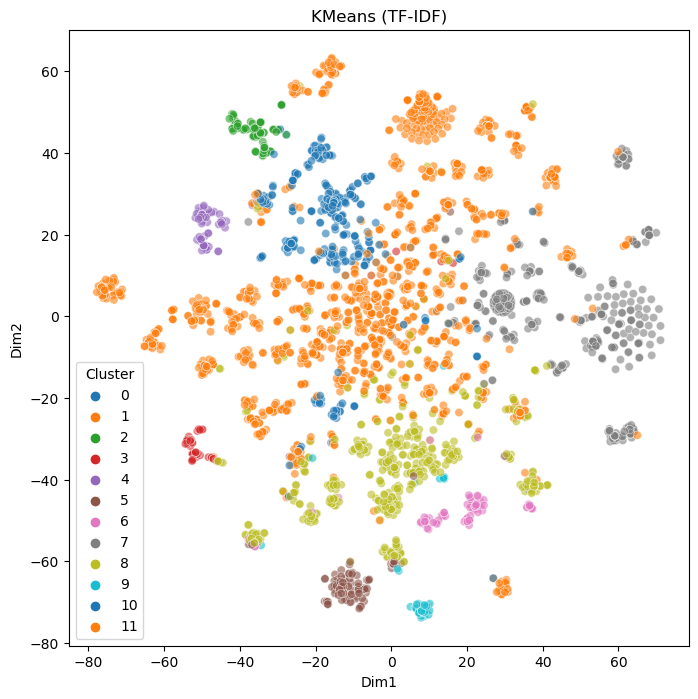

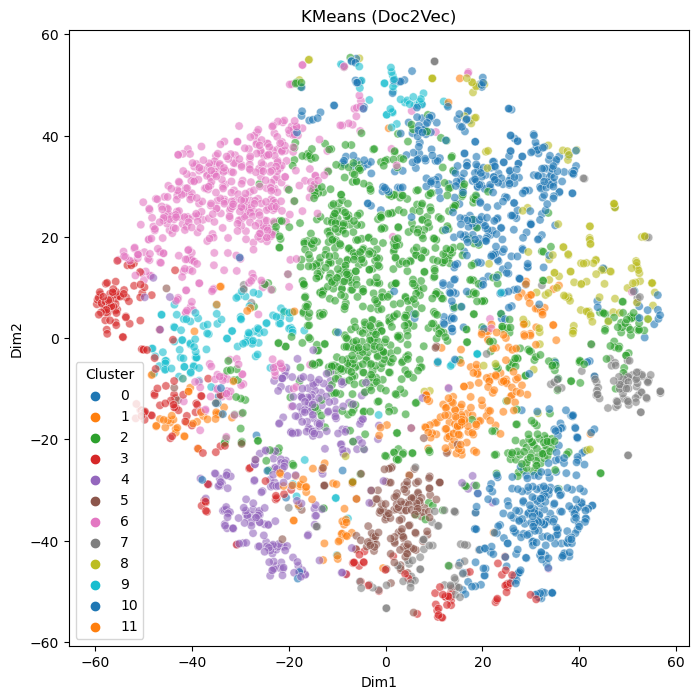

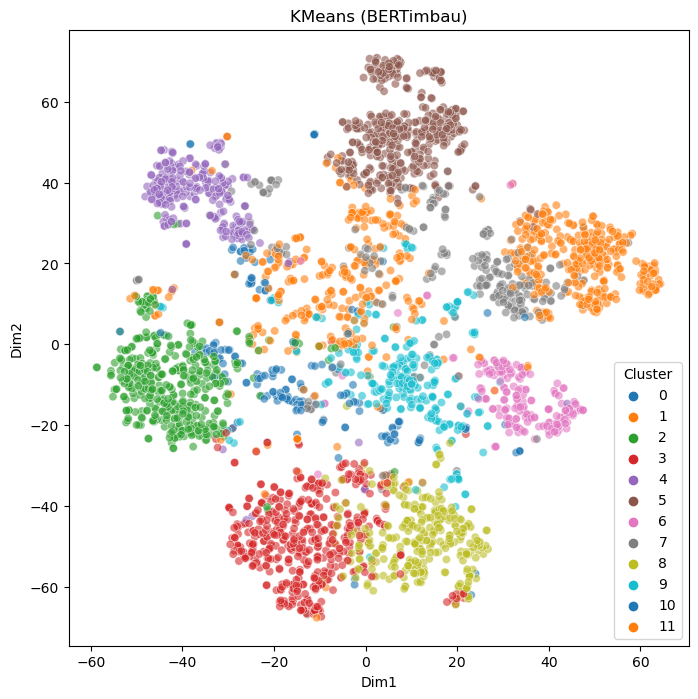

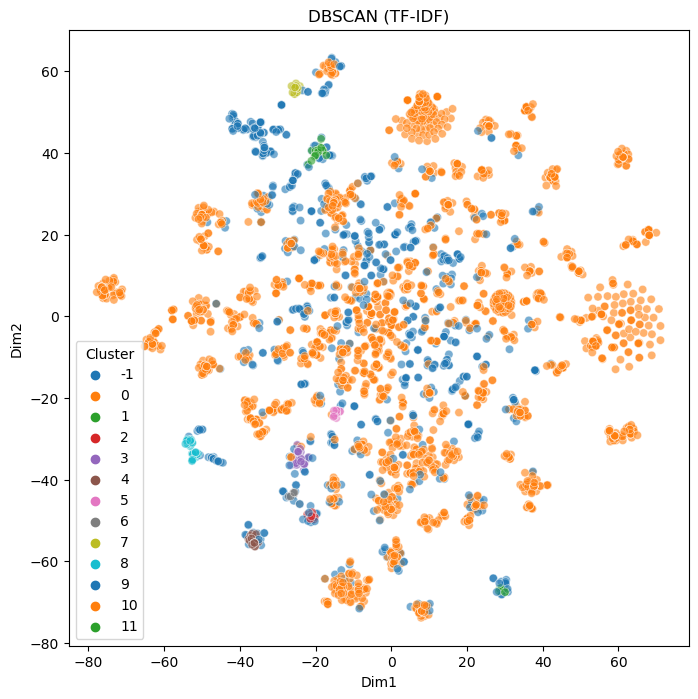

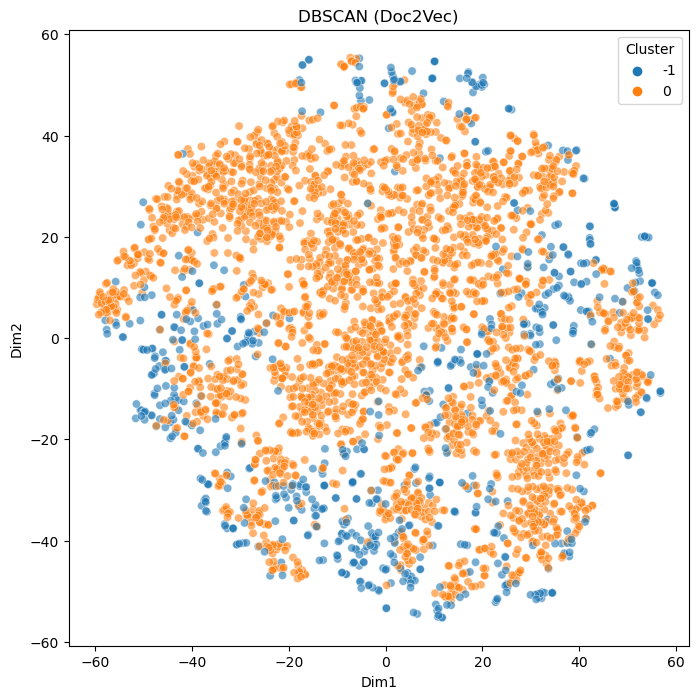

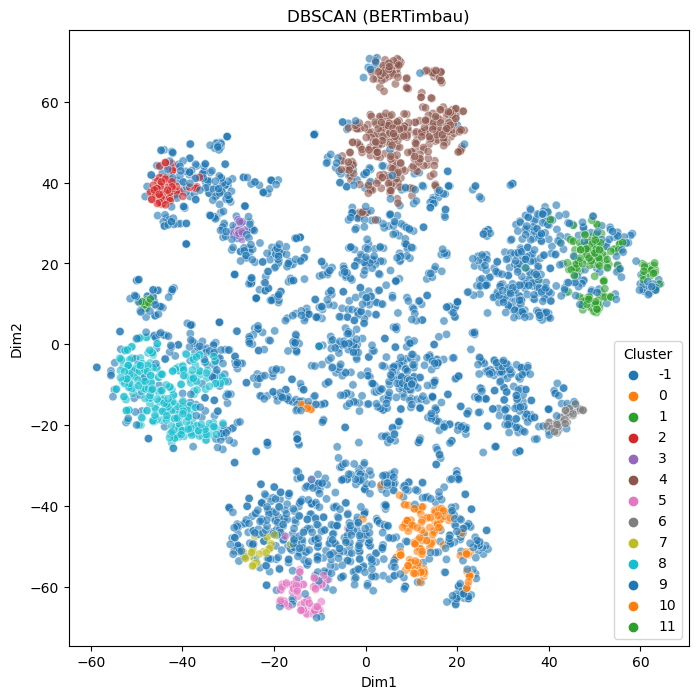

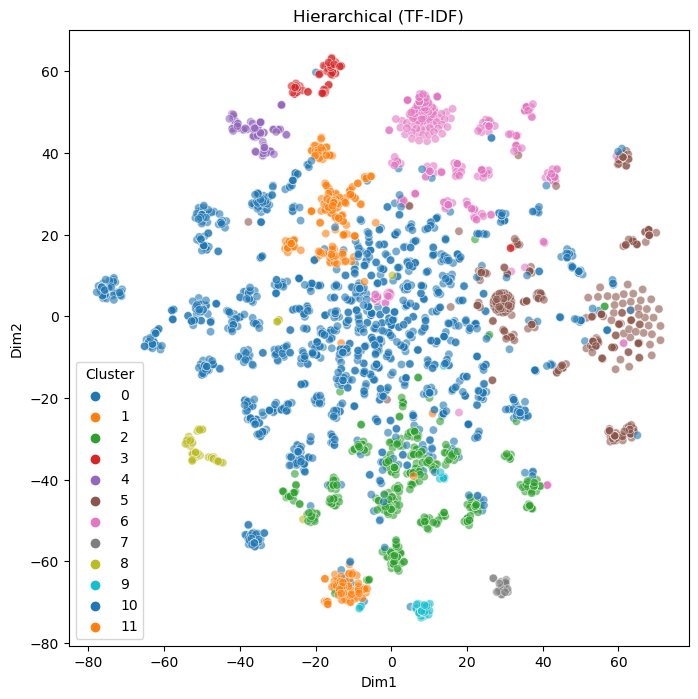

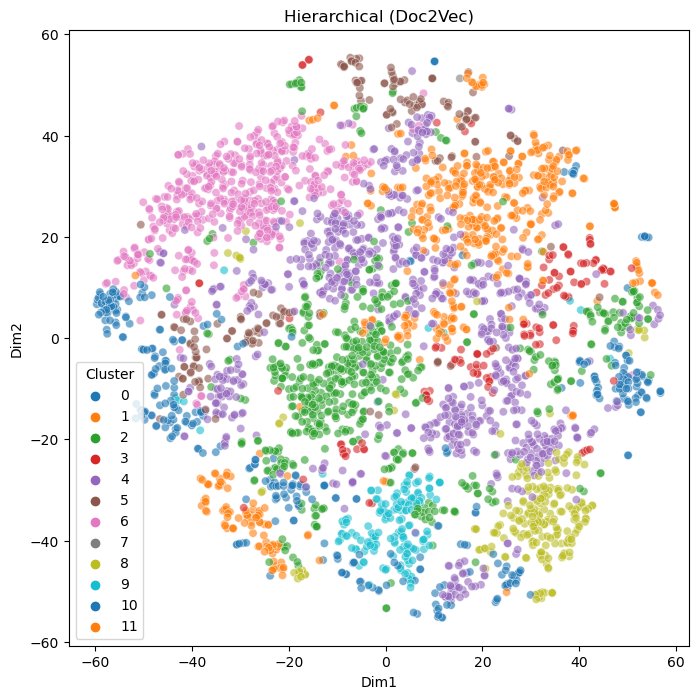

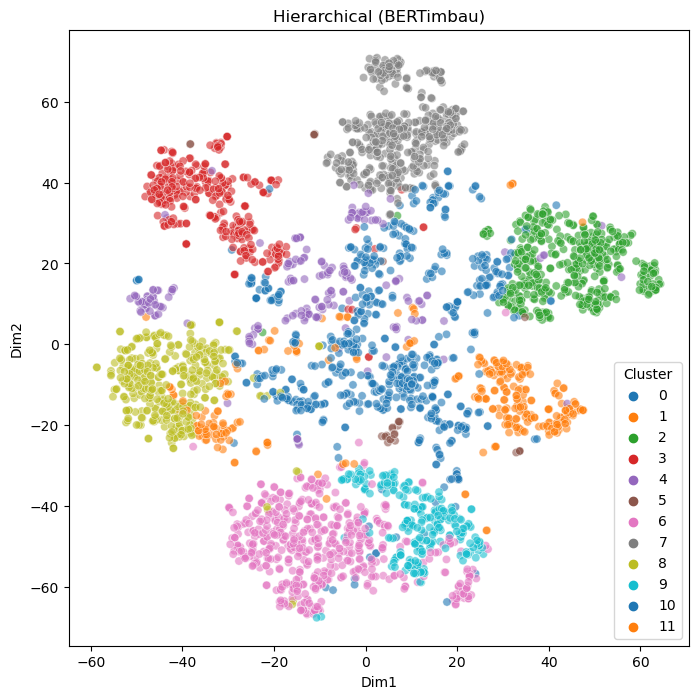

In [438]:
plot_tsne_separated(tsne_results_full, labels_list, titles_list)

### Distribuição dos Clusters

A distribuição dos documentos entre os diferentes clusters pode nos dar uma ideia da densidade e distribuição dos tópicos das ementas.

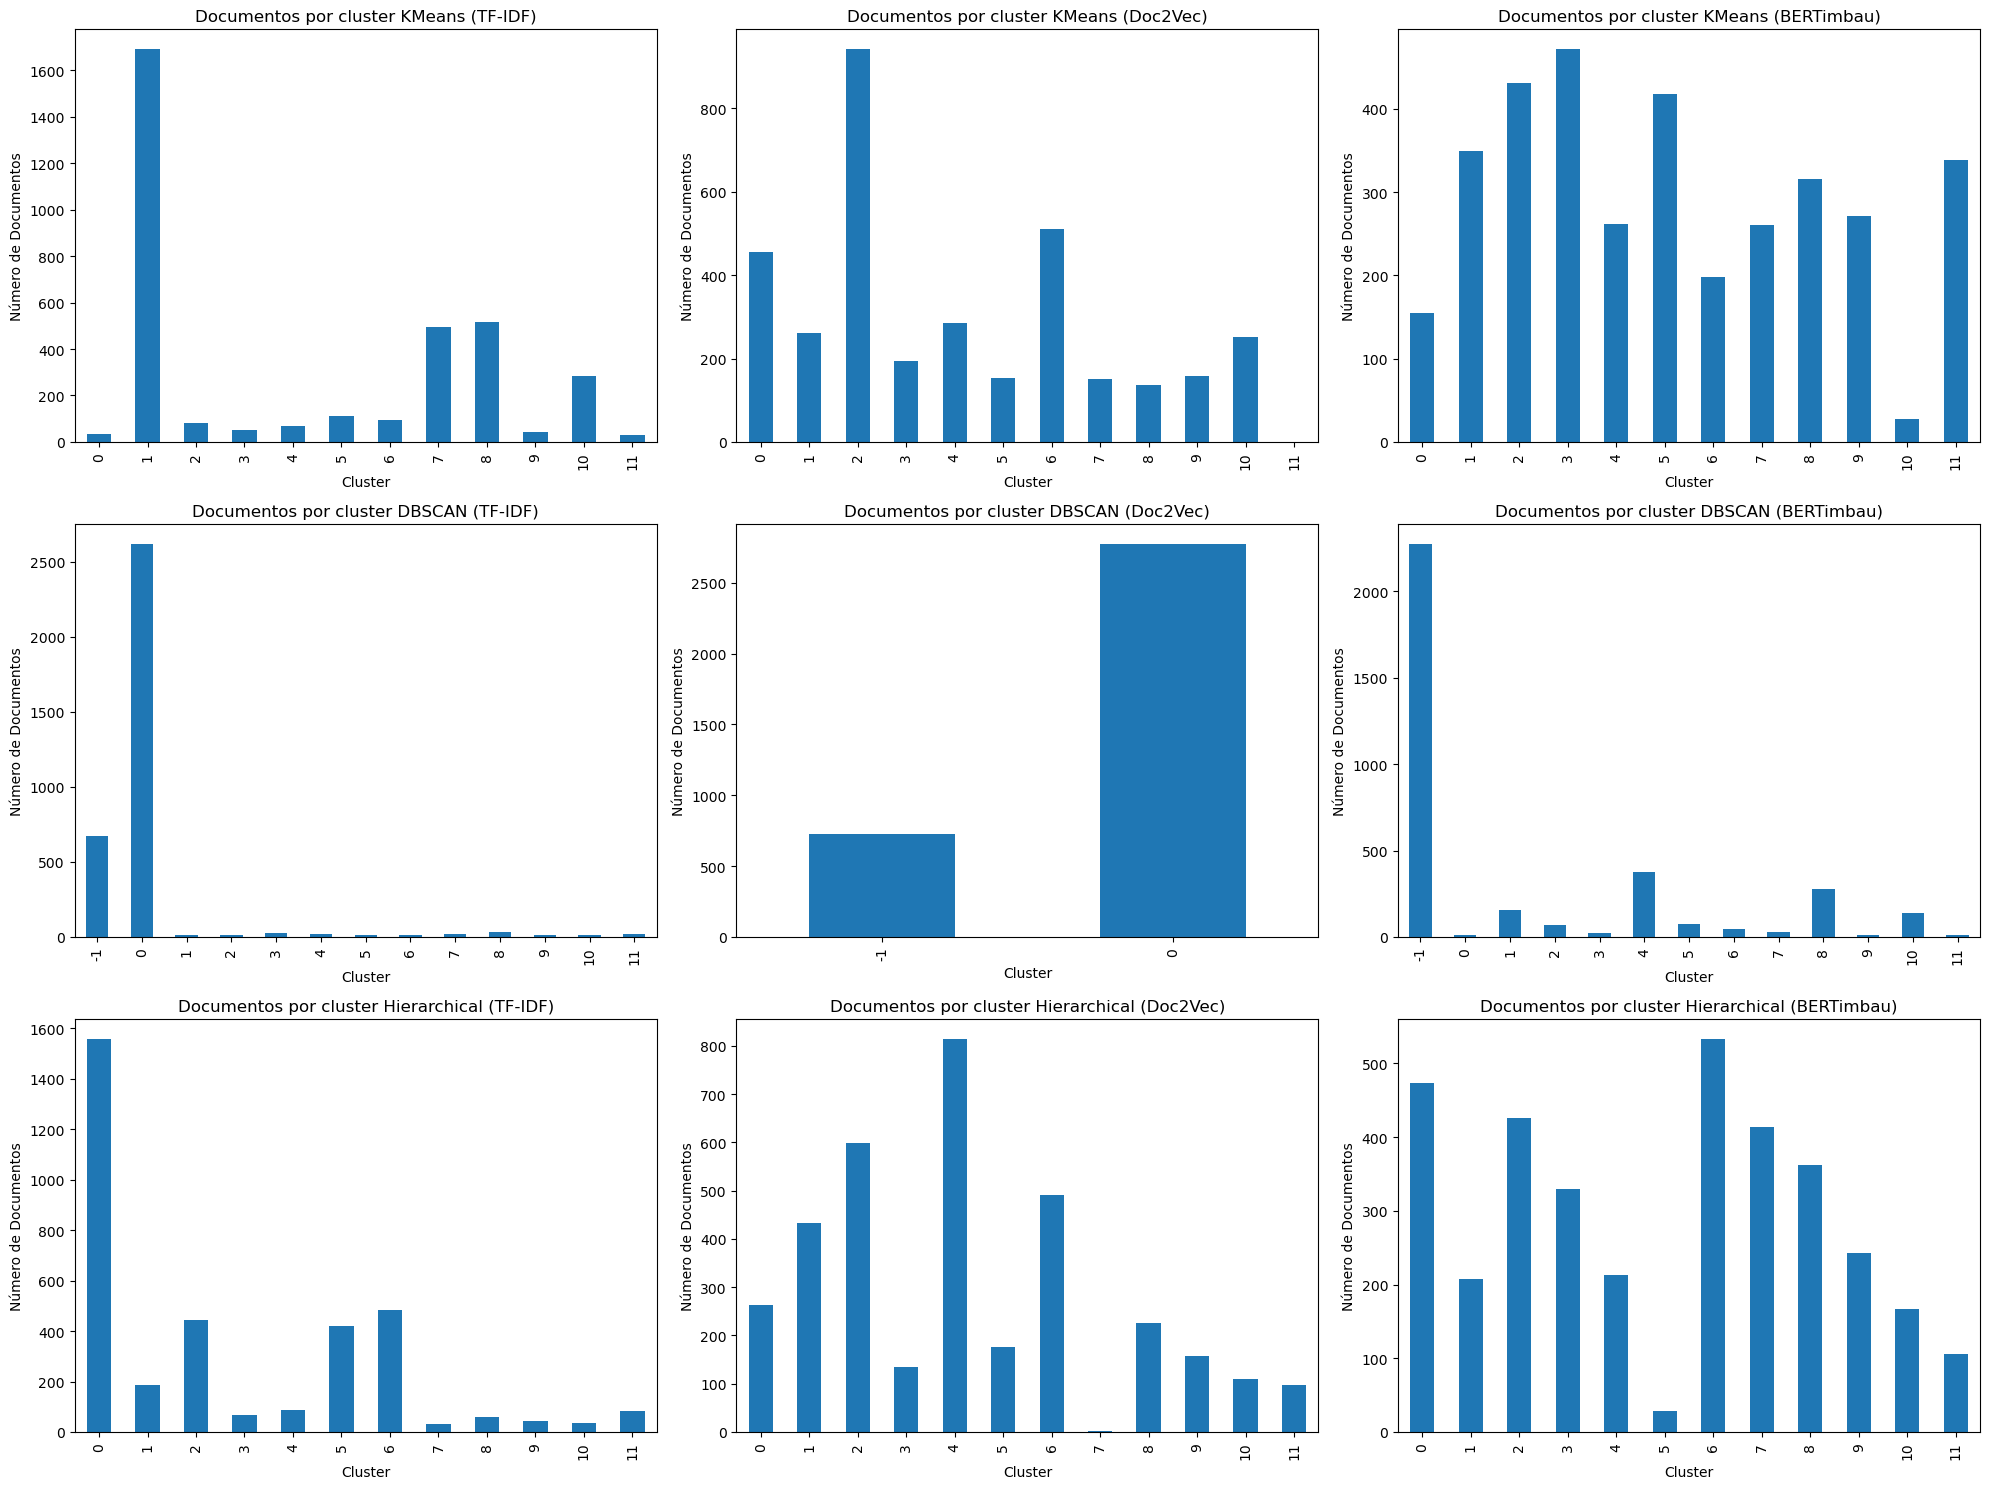

In [439]:
def compute_cluster_distributions(labels_list):
    """
    Calcula as distribuições de clusters para cada conjunto de rótulos.
    """
    distributions = []
    for labels in labels_list:
        distribution = pd.Series(labels).value_counts().sort_index()
        distributions.append(distribution)
    return distributions

def plot_cluster_distributions(distributions, titles_list):
    """
    Plota um grid de gráficos de barras mostrando a distribuição dos clusters.
    """
    plt.figure(figsize=(20, 15))
    
    for i, (distribution, title) in enumerate(zip(distributions, titles_list)):
        plt.subplot(3, 3, i+1)
        distribution.plot(kind='bar')
        plt.title(f'Documentos por cluster {title}')
        plt.xlabel('Cluster')
        plt.ylabel('Número de Documentos')
        
    plt.tight_layout()
    plt.show()

# Exemplo de uso
labels_list = [
    df['kmeans_labels_tfidf'], df['kmeans_labels_doc2vec'], df['kmeans_labels_bertimbau'],
    df['dbscan_labels_tfidf'], df['dbscan_labels_doc2vec'], df['dbscan_labels_bertimbau'],
    df['agg_labels_tfidf'], df['agg_labels_doc2vec'], df['agg_labels_bertimbau']
]
titles_list = [
    'KMeans (TF-IDF)', 'KMeans (Doc2Vec)', 'KMeans (BERTimbau)',
    'DBSCAN (TF-IDF)', 'DBSCAN (Doc2Vec)', 'DBSCAN (BERTimbau)',
    'Hierarchical (TF-IDF)', 'Hierarchical (Doc2Vec)', 'Hierarchical (BERTimbau)'
]

distributions = compute_cluster_distributions(labels_list)
plot_cluster_distributions(distributions, titles_list)

In [440]:
def plot_cluster_distributions_separate(distributions, titles_list):
    """
    Plota gráficos de barras individualmente mostrando a distribuição dos clusters.
    """
    for i, (distribution, title) in enumerate(zip(distributions, titles_list)):
        # Criando uma nova figura para cada gráfico
        plt.figure(figsize=(10, 6))

        # Plotando a distribuição de clusters
        distribution.plot(kind='bar')
        plt.title(f'Documentos por cluster - {title}')
        plt.xlabel('Cluster')
        plt.ylabel('Número de Documentos')

        # Exibindo o gráfico
        plt.show()

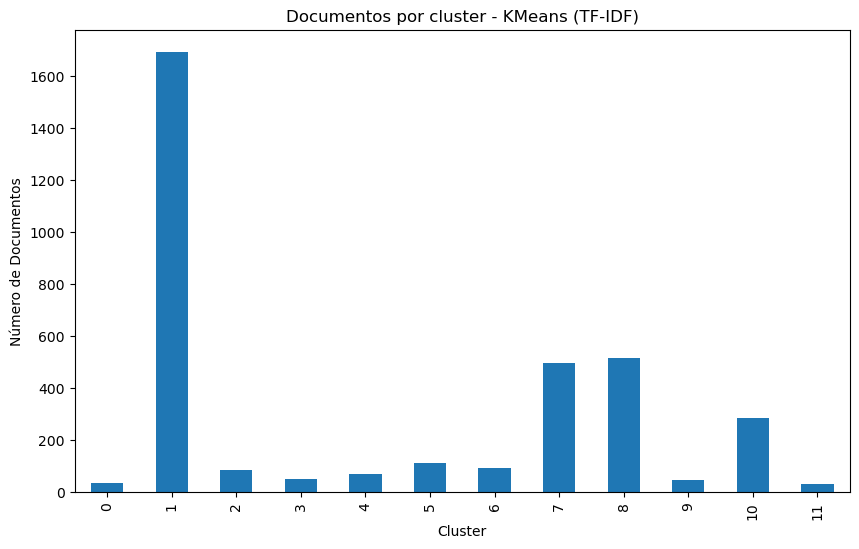

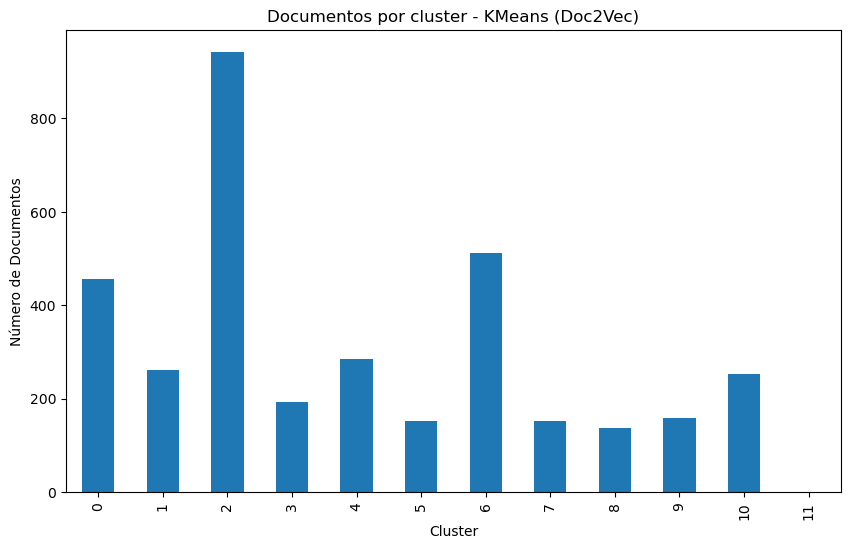

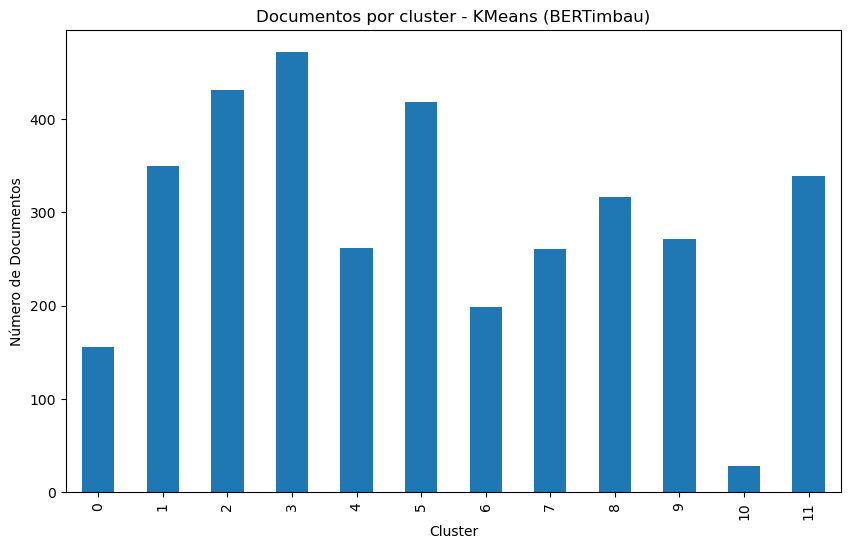

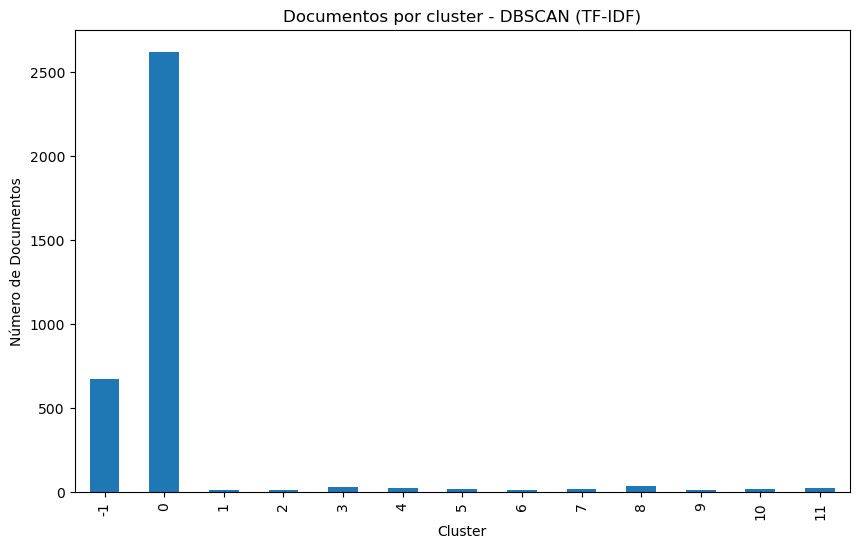

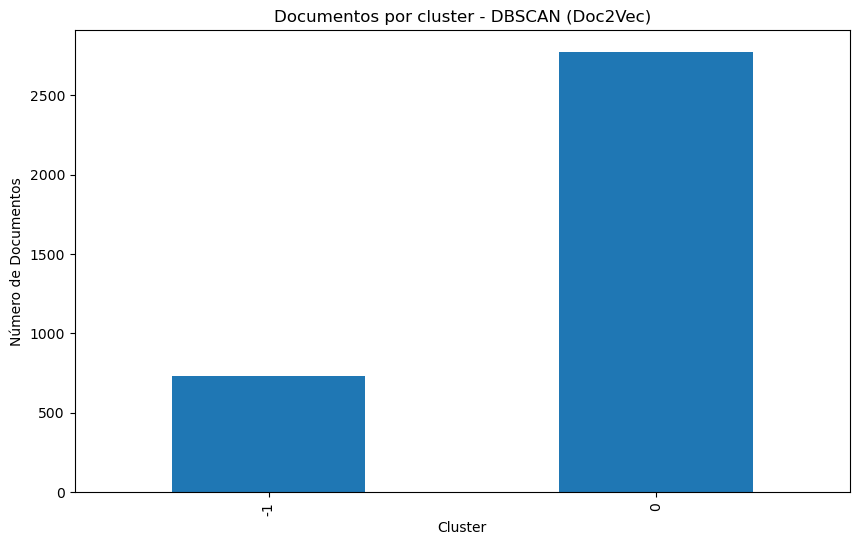

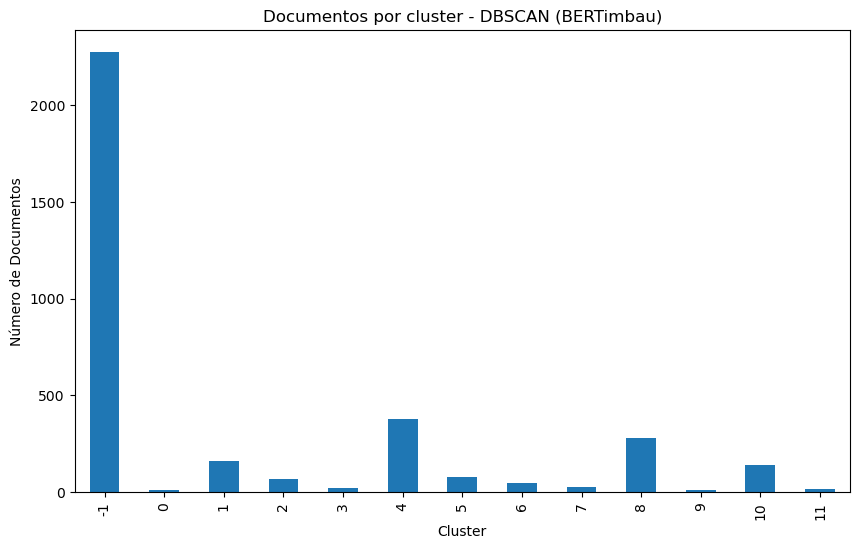

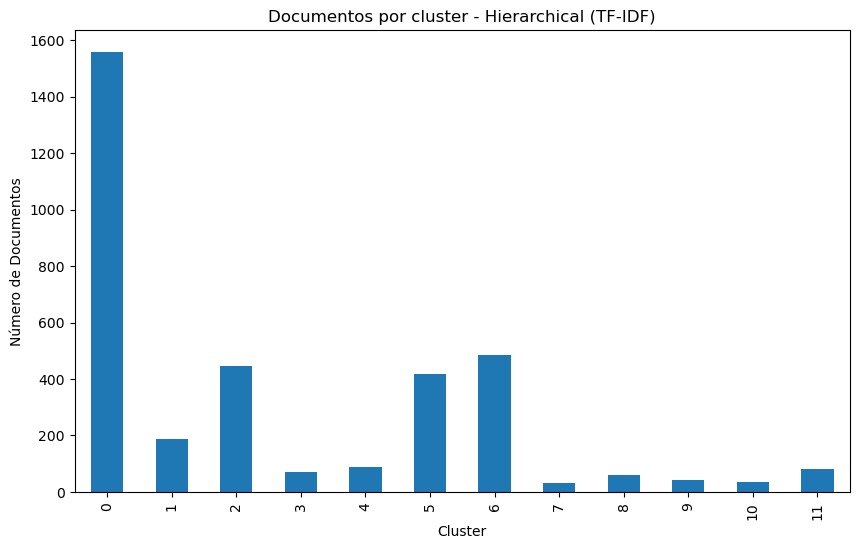

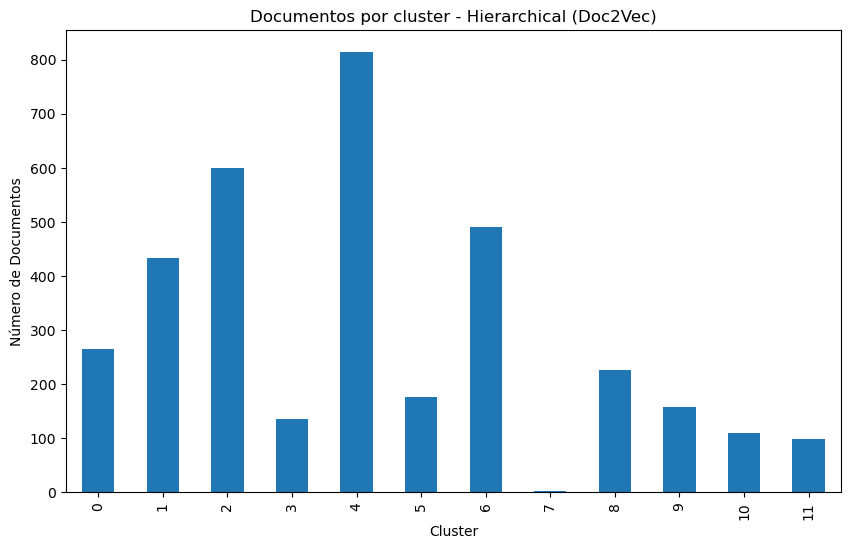

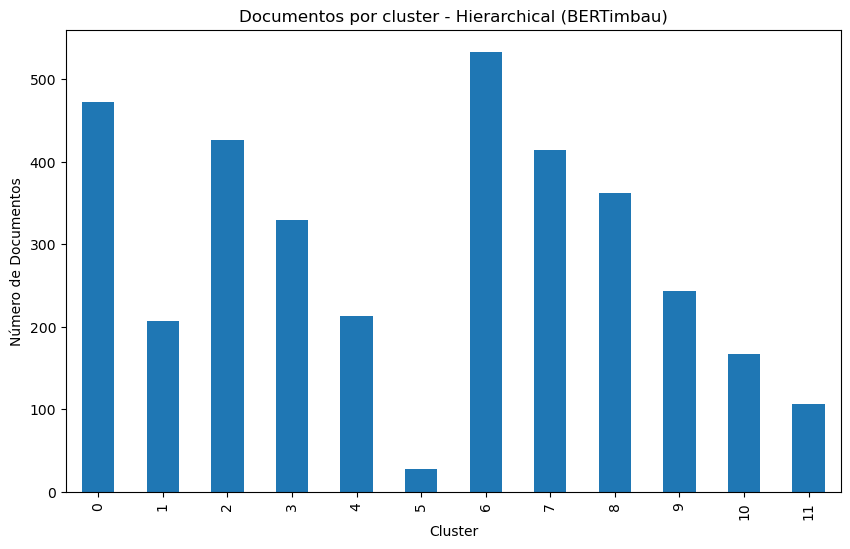

In [441]:
plot_cluster_distributions_separate(distributions, titles_list)

### Análise de Exemplos

In [63]:
def display_cluster_samples(df, label_column, num_clusters, num_samples=5):
    """
    Exibe amostras de documentos para cada cluster.

    Parâmetros:
    - df: DataFrame contendo os dados e rótulos dos clusters.
    - label_column: Nome da coluna contendo os rótulos dos clusters.
    - num_clusters: Número total de clusters.
    - num_samples: Número de amostras de documentos a serem exibidos para cada cluster.
    """
    for i in range(num_clusters):
        print(f"Cluster {i}:\n")
        print(df[df[label_column] == i]['summary'].head(num_samples))
        print("\n" + "="*50 + "\n")

In [442]:
def display_cluster_samples_for_all(df):
    # Definindo os pares (coluna, nome do método)
    methods = [
        ('kmeans_labels_tfidf', 'KMeans TF-IDF'),
        ('dbscan_labels_tfidf', 'DBSCAN TF-IDF'),
        ('agg_labels_tfidf', 'Hierarchical Clustering TF-IDF'),
        ('kmeans_labels_doc2vec', 'KMeans Doc2Vec'),
        ('dbscan_labels_doc2vec', 'DBSCAN Doc2Vec'),
        ('agg_labels_doc2vec', 'Hierarchical Clustering Doc2Vec'),
        ('kmeans_labels_bertimbau', 'KMeans BERTimbau'),
        ('dbscan_labels_bertimbau', 'DBSCAN BERTimbau'),
        ('agg_labels_bertimbau', 'Hierarchical Clustering BERTimbau'),
    ]
    
    # Iterando sobre os métodos e exibindo as amostras
    for column, method_name in methods:
        num_clusters = df[column].nunique()
        print(f"Samples for {method_name}:\n")
        display_cluster_samples(df, column, num_clusters)
        print("\n" + "="*100 + "\n")

# Executando a função
with pd.option_context('display.max_colwidth', None):
    display_cluster_samples_for_all(df)

Samples for KMeans TF-IDF:

Cluster 0:

260                                                            ampliação cargo arrecadador judicial tributo junto quadro permanente prefeitura municipal sorocaba
1154              localização estabelecimento farmacêutico horário funcionamento instituição regime plantão permanente semanal feriado farmácia drogaria sorocaba
1241    publicação sítio oficial nome cargo empregado empresa prestador serviço terceirizar vencedora licitação atuar junto administração público direto indireto
1699                                                                             ampliação cargo assessor técnico quadro permanente prefeitura municipal sorocaba
1727                            dar novo redação lei nº   token_data criar ampliar extinguir regulamentar cargo quadro permanente administração direto autárquico
Name: summary, dtype: object


Cluster 1:

0                                                                                                    estima

In [448]:
df.columns

Index(['summary', 'leis_orcamentarias_e_creditos_adicionais',
       'teor_tributario', 'titulo_de_utilidade_publica', 'dias_tematicos',
       'denominacoes_de_proprios_publicos',
       'estrutura_administracao_publica_e_servidores', 'titulos_honorificos',
       'urbanismo_e_obras', 'normas_sobre_bancos', 'revogacoes', 'alteracoes',
       'convenios', 'kmeans_labels_tfidf', 'kmeans_labels_doc2vec',
       'kmeans_labels_bertimbau', 'dbscan_labels_tfidf',
       'dbscan_labels_doc2vec', 'dbscan_labels_bertimbau', 'agg_labels_tfidf',
       'agg_labels_doc2vec', 'agg_labels_bertimbau'],
      dtype='object')

In [449]:
df.columns = ['summary', 'orcamento_e_creditos',
       'teor_tributario', 'utilidade_publica', 'dias_tematicos',
       'denominacoes',
       'estrutura_administracao', 'titulos_honorificos',
       'urbanismo_e_obras', 'normas_sobre_bancos', 'revogacoes', 'alteracoes',
       'convenios', 'kmeans_labels_tfidf', 'kmeans_labels_doc2vec',
       'kmeans_labels_bertimbau', 'dbscan_labels_tfidf',
       'dbscan_labels_doc2vec', 'dbscan_labels_bertimbau', 'agg_labels_tfidf',
       'agg_labels_doc2vec', 'agg_labels_bertimbau']

In [480]:
results = []
dfs = []

for cluster in ['kmeans_labels_tfidf', 'kmeans_labels_doc2vec', 'kmeans_labels_bertimbau', 
                'dbscan_labels_tfidf', 'dbscan_labels_doc2vec', 'dbscan_labels_bertimbau',
                'agg_labels_tfidf', 'agg_labels_doc2vec', 'agg_labels_bertimbau'
                ] : 
    group_columns = ['orcamento_e_creditos', 'teor_tributario', 'utilidade_publica', 'dias_tematicos',
       'denominacoes',
       'estrutura_administracao', 'titulos_honorificos',
       'urbanismo_e_obras', 'normas_sobre_bancos', 'revogacoes', 'alteracoes',
       'convenios']
    contingency_tables = []
    for group in group_columns:
        table = pd.crosstab(index=df[cluster], columns=df[group])
        contingency_tables.append(table.loc[:, True])  # Pegamos apenas as linhas onde o valor é True

    contingency_df = pd.concat(contingency_tables, axis=1)
    contingency_df.columns = group_columns  # Renomeamos as colunas para os nomes dos grupos
    contingency_df.reset_index(inplace=True)
    dfs.append(contingency_df)

    print(f'Tabela de contingência para o cluster "{cluster}":')
    display(contingency_df)

    latex_table = contingency_df.to_latex(index=False, longtable=True, multicolumn=True, multirow=True,
                                          caption=f"Tabela de contingência para o cluster '{cluster}'", 
                                          label=f"tab:{cluster}", escape=True)
    print(latex_table)
    print()

    # Calcula a entropia e o índice de Gini
    entropies = []
    ginis = []
    for index, row in contingency_df.iterrows():
        total = row.sum()
        entropy = -sum((n / total) * np.log2(n / total) if n > 0 else 0 for n in row)
        gini = 1 - sum((n / total) ** 2 for n in row)
        entropies.append(entropy)
        ginis.append(gini)
    
    # Salva os resultados
    results.append({
        'Algoritmo': cluster,
        'Entropia média': np.mean(entropies),
        'Índice de Gini médio': np.mean(ginis),
    })

# Cria um DataFrame com os resultados
df_results = pd.DataFrame(results)
display(df_results)

Tabela de contingência para o cluster "kmeans_labels_tfidf":


kmeans_labels_tfidf  orcamento_e_creditos  teor_tributario  \
0                     0                     0                1   
1                     1                    47              211   
2                     2                     0                1   
3                     3                     0                1   
4                     4                    70                0   
5                     5                     0                5   
6                     6                     0                4   
7                     7                     0                1   
8                     8                    10               38   
9                     9                     0                3   
10                   10                     5                3   
11                   11                     2                2   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                   0               1             1                       32   
1                   3             256           527                      321   
2                   0               0             1                        1   
3                   0               0             1                        0   
4                   0               0             0                        4   
5                   4               1            12                        6   
6                   0               1            62                        2   
7                 495               0             2                       11   
8                   4              16            21                      112   
9                   0               1             1                        4   
10                  0               0             0                       10   
11                  1               0             0                       19   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     0                  2                    0           0   
1                    17                303                   11           2   
2                     0                 21                    0           0   
3                     0                 48                    0           0   
4                     0                  3                    0           0   
5                     0                 15                    0           3   
6                     0                  5                    1          12   
7                     0                  9                    0           1   
8                     0                 42                    2          94   
9                     0                  7                    0          10   
10                    0                 52                    0           0   
11                    0                  1                    0           0   

    alteracoes  convenios  
0            5          1  
1            4         90  
2            4         83  
3            2          1  
4            1          0  
5          109          1  
6           83          0  
7            0          0  
8          349         14  
9           36          0  
10           3        241  
11          10          2

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'kmeans_labels_tfidf'} \label{tab:kmeans_labels_tfidf} \\
\toprule
kmeans\_labels\_tfidf & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'kmeans_labels_tfidf'} \\
\toprule
kmeans\_labels\_tfidf & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 0 & 1 & 0 & 1 & 1 & 32 & 0 & 2 & 0 & 0 & 5 & 1 \\
1 & 47 & 211 & 3 & 256 & 527 & 321 & 17 & 303 & 11 & 2 & 4 & 

kmeans_labels_doc2vec  orcamento_e_creditos  teor_tributario  \
0                       0                    17               48   
1                       1                    25              114   
2                       2                    46               44   
3                       3                     8               12   
4                       4                     8                2   
5                       5                     5                9   
6                       6                     3                6   
7                       7                     5                4   
8                       8                     9               16   
9                       9                     5                4   
10                     10                     3               10   
11                     11                     0                1   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                  30              25            35                       72   
1                   1               2             3                        6   
2                 263              79           114                      118   
3                   5               6            67                       27   
4                 180               4             3                       16   
5                   1               0             3                      127   
6                  20               5           386                        9   
7                   0               1             4                      113   
8                   0               0             1                       24   
9                   4               0             7                        2   
10                  3             154             5                        8   
11                  0               0             0                        0   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     1                 92                    2          40   
1                     0                 63                    4           7   
2                     2                 60                    2          21   
3                     0                 17                    0          14   
4                     0                 17                    0           1   
5                     0                  5                    0           2   
6                     1                 66                    0          13   
7                     0                 20                    0           2   
8                     0                 38                    0           4   
9                     0                109                    0          16   
10                   13                 20                    6           2   
11                    0                  1                    0           0   

    alteracoes  convenios  
0           75         66  
1           43         34  
2          143        105  
3          121         18  
4            5         77  
5           20          7  
6           66         19  
7           43          8  
8           17         66  
9           33         21  
10          40         12  
11           0          0

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'kmeans_labels_doc2vec'} \label{tab:kmeans_labels_doc2vec} \\
\toprule
kmeans\_labels\_doc2vec & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'kmeans_labels_doc2vec'} \\
\toprule
kmeans\_labels\_doc2vec & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 17 & 48 & 30 & 25 & 35 & 72 & 1 & 92 & 2 & 40 & 75 & 66 \\
1 & 25 & 114 & 1 & 2 & 3 & 6 & 0 & 63 & 4 

kmeans_labels_bertimbau  orcamento_e_creditos  teor_tributario  \
0                         0                    59               18   
1                         1                     0                0   
2                         2                     9                8   
3                         3                     9               38   
4                         4                     0                3   
5                         5                     0                0   
6                         6                     2                3   
7                         7                    15               15   
8                         8                     0               17   
9                         9                    18              146   
10                       10                     0                9   
11                       11                    22               13   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                   2               1             3                       29   
1                 342               0             3                       12   
2                   1               2             3                       11   
3                   9              15            87                      112   
4                   0             222             1                       11   
5                   5               4           410                        0   
6                   0               0             3                      196   
7                 135              22            30                       16   
8                   2               1             3                       27   
9                   3               2            13                       45   
10                  0               3             6                        6   
11                  8               4            66                       57   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     0                 34                    1           1   
1                     0                  7                    0           0   
2                     0                 96                    0           0   
3                     0                 55                    3          47   
4                    14                 13                    0           0   
5                     0                 16                    0           1   
6                     0                  0                    0           0   
7                     0                 31                    1           1   
8                     0                 25                    0          68   
9                     0                 57                    2           0   
10                    0                  6                    0           3   
11                    3                168                    7           1   

    alteracoes  convenios  
0            2         22  
1            0          5  
2            3        358  
3          365         18  
4            1          1  
5            1          0  
6            0          0  
7            0          4  
8          228          3  
9            0          3  
10           4          2  
11           2         17

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'kmeans_labels_bertimbau'} \label{tab:kmeans_labels_bertimbau} \\
\toprule
kmeans\_labels\_bertimbau & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'kmeans_labels_bertimbau'} \\
\toprule
kmeans\_labels\_bertimbau & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 59 & 18 & 2 & 1 & 3 & 29 & 0 & 34 & 1 & 1 & 2 & 22 \\
1 & 0 & 0 & 342 & 0 & 3 & 12 & 0 & 7 

dbscan_labels_tfidf  orcamento_e_creditos  teor_tributario  \
0                    -1                    27               97   
1                     0                   105              169   
2                     1                     2                1   
3                     2                     0                1   
4                     3                     0                1   
5                     4                     0                1   
6                     5                     0                0   
7                     6                     0                0   
8                     7                     0                0   
9                     8                     0                0   
10                    9                     0                0   
11                   10                     0                0   
12                   11                     0                0   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                   7               6            33                      106   
1                 496             270           589                      348   
2                   1               0             0                        9   
3                   2               0             1                        2   
4                   1               0             0                       27   
5                   0               0             3                        2   
6                   0               0             0                       16   
7                   0               0             0                       10   
8                   0               0             0                        2   
9                   0               0             1                        0   
10                  0               0             1                        0   
11                  0               0             0                        0   
12                  0               0             0                        0   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     0                183                    5          13   
1                    17                275                    9         105   
2                     0                  0                    0           0   
3                     0                  1                    0           0   
4                     0                  0                    0           1   
5                     0                  2                    0           3   
6                     0                  0                    0           0   
7                     0                  0                    0           0   
8                     0                  2                    0           0   
9                     0                 33                    0           0   
10                    0                  9                    0           0   
11                    0                  1                    0           0   
12                    0                  2                    0           0   

    alteracoes  convenios  
0          112        230  
1          440        129  
2            2          1  
3           14          0  
4            7          2  
5           18          0  
6            3          0  
7            8          0  
8            0         20  
9            0          0  
10           1         14  
11           1         16  
12           0         21

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'dbscan_labels_tfidf'} \label{tab:dbscan_labels_tfidf} \\
\toprule
dbscan\_labels\_tfidf & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'dbscan_labels_tfidf'} \\
\toprule
dbscan\_labels\_tfidf & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
-1 & 27 & 97 & 7 & 6 & 33 & 106 & 0 & 183 & 5 & 13 & 112 & 230 \\
0 & 105 & 169 & 496 & 270 & 589 & 348 & 17 & 275 

dbscan_labels_doc2vec  orcamento_e_creditos  teor_tributario  \
0                     -1                    43               85   
1                      0                    91              185   

   utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                 26              27            37                      135   
1                481             249           591                      387   

   titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                    3                186                    2          29   
1                   14                322                   12          93   

   alteracoes  convenios  
0         160        187  
1         446        246

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'dbscan_labels_doc2vec'} \label{tab:dbscan_labels_doc2vec} \\
\toprule
dbscan\_labels\_doc2vec & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'dbscan_labels_doc2vec'} \\
\toprule
dbscan\_labels\_doc2vec & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
-1 & 43 & 85 & 26 & 27 & 37 & 135 & 3 & 186 & 2 & 29 & 160 & 187 \\
0 & 91 & 185 & 481 & 249 & 591 & 387 

dbscan_labels_bertimbau  orcamento_e_creditos  teor_tributario  \
0                        -1                   122              269   
1                         0                    11                0   
2                         1                     0                0   
3                         2                     0                0   
4                         3                     0                0   
5                         4                     0                0   
6                         5                     0                0   
7                         6                     0                0   
8                         7                     0                1   
9                         8                     1                0   
10                        9                     0                0   
11                       10                     0                0   
12                       11                     0                0   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                 347             185           184                      445   
1                   0               0             0                        0   
2                 159               0             1                        3   
3                   0              69             0                        0   
4                   0              21             0                        0   
5                   0               0           375                        0   
6                   0               0            66                        4   
7                   0               0             0                       47   
8                   0               1             0                       17   
9                   0               0             1                        4   
10                  0               0             0                        0   
11                  1               0             1                        2   
12                  0               0             0                        0   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     6                430                   14          73   
1                     0                  0                    0           0   
2                     0                  3                    0           0   
3                     0                  0                    0           0   
4                     0                  0                    0           0   
5                     0                 14                    0           0   
6                     0                  2                    0          13   
7                     0                  0                    0           0   
8                     0                  1                    0           1   
9                     0                 52                    0           0   
10                   11                  1                    0           0   
11                    0                  1                    0          35   
12                    0                  4                    0           0   

    alteracoes  convenios  
0          411        161  
1            0          0  
2            0          0  
3            0          0  
4            0          0  
5            0          0  
6           63          0  
7            0          0  
8           25          0  
9            2        259  
10           0          0  
11         105          0  
12           0         13

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'dbscan_labels_bertimbau'} \label{tab:dbscan_labels_bertimbau} \\
\toprule
dbscan\_labels\_bertimbau & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'dbscan_labels_bertimbau'} \\
\toprule
dbscan\_labels\_bertimbau & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
-1 & 122 & 269 & 347 & 185 & 184 & 445 & 6 & 430 & 14 & 73 & 411 & 161 \\
0 & 11 & 0 & 0 & 0 & 

agg_labels_tfidf  orcamento_e_creditos  teor_tributario  \
0                  0                   125              228   
1                  1                     2                3   
2                  2                     4               20   
3                  3                     0                0   
4                  4                     0                2   
5                  5                     1                2   
6                  6                     0                1   
7                  7                     2                2   
8                  8                     0                1   
9                  9                     0                2   
10                10                     0                4   
11                11                     0                5   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                  81             264            69                      413   
1                   0               0             0                        5   
2                   8               9            71                       64   
3                   0               0             0                        3   
4                   0               0             1                        1   
5                 405               0             8                        8   
6                   8               0           463                        0   
7                   1               0             0                       20   
8                   0               0             1                        0   
9                   0               1             2                        3   
10                  0               1             3                        3   
11                  4               1            10                        2   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                    16                295                   12          17   
1                     0                 36                    0           0   
2                     0                 24                    2          86   
3                     0                  7                    0           0   
4                     0                 22                    0           0   
5                     1                 11                    0           0   
6                     0                 36                    0           4   
7                     0                  1                    0           0   
8                     0                 53                    0           1   
9                     0                  6                    0           9   
10                    0                  6                    0           3   
11                    0                 11                    0           2   

    alteracoes  convenios  
0          107        108  
1            3        156  
2          329          9  
3            0         69  
4            4         87  
5            0          0  
6            1          0  
7           11          2  
8            6          1  
9           35          0  
10          28          0  
11          82          1

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'agg_labels_tfidf'} \label{tab:agg_labels_tfidf} \\
\toprule
agg\_labels\_tfidf & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'agg_labels_tfidf'} \\
\toprule
agg\_labels\_tfidf & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 125 & 228 & 81 & 264 & 69 & 413 & 16 & 295 & 12 & 17 & 107 & 108 \\
1 & 2 & 3 & 0 & 0 & 0 & 5 & 0 & 36 & 0 & 0 & 3 & 156 \\
2 

agg_labels_doc2vec  orcamento_e_creditos  teor_tributario  \
0                    0                     8               28   
1                    1                    18               38   
2                    2                     8                6   
3                    3                    16               24   
4                    4                    61              145   
5                    5                     2                3   
6                    6                     0                3   
7                    7                     0                1   
8                    8                     0                6   
9                    9                    14               11   
10                  10                     6                4   
11                  11                     1                1   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                   8              15            53                       29   
1                  52              15            30                       93   
2                 284               6            12                      112   
3                   0               0             3                        7   
4                  71              87            70                       62   
5                   2               0             8                        1   
6                   7               0           437                        7   
7                   0               0             0                        0   
8                  14             151             5                        8   
9                   0               0             5                      119   
10                  1               2             3                       75   
11                 68               0             2                        9   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     0                 37                    0          13   
1                     0                 50                    0          44   
2                     1                 39                    0           7   
3                     0                 45                    0           0   
4                     4                116                   13          23   
5                     0                117                    0          14   
6                     0                 51                    0          14   
7                     0                  1                    0           0   
8                    12                 20                    1           2   
9                     0                 10                    0           1   
10                    0                 16                    0           1   
11                    0                  6                    0           3   

    alteracoes  convenios  
0          127         52  
1           82         65  
2           59        136  
3            7         58  
4          208         46  
5           35         34  
6           24         10  
7            0          0  
8           17          3  
9           18          2  
10          23          3  
11           6         24

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'agg_labels_doc2vec'} \label{tab:agg_labels_doc2vec} \\
\toprule
agg\_labels\_doc2vec & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'agg_labels_doc2vec'} \\
\toprule
agg\_labels\_doc2vec & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 8 & 28 & 8 & 15 & 53 & 29 & 0 & 37 & 0 & 13 & 127 & 52 \\
1 & 18 & 38 & 52 & 15 & 30 & 93 & 0 & 50 & 0 & 44 & 82 & 6

agg_labels_bertimbau  orcamento_e_creditos  teor_tributario  \
0                      0                    99              160   
1                      1                     0                8   
2                      2                     0                0   
3                      3                     1                8   
4                      4                    12                7   
5                      5                     0                9   
6                      6                     3               46   
7                      7                     0                0   
8                      8                     9                6   
9                      9                     2                7   
10                    10                     1               10   
11                    11                     7                9   

    utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
0                   5               2            22                       62   
1                   0               1             4                      199   
2                 423               0             4                       11   
3                   0             242             7                       32   
4                   7               2            33                       35   
5                   0               3             6                        6   
6                   7              15            86                      104   
7                   0               3           411                        0   
8                   1               1             2                        9   
9                   3               5             8                       32   
10                 59               2            45                        7   
11                  2               0             0                       25   

    titulos_honorificos  urbanismo_e_obras  normas_sobre_bancos  revogacoes  \
0                     0                127                   10           1   
1                     0                  0                    0           0   
2                     0                  9                    0           0   
3                    16                 31                    0           0   
4                     1                 86                    1           0   
5                     0                  6                    0           3   
6                     0                 58                    3          67   
7                     0                 18                    0           0   
8                     0                 79                    0           0   
9                     0                 19                    0          51   
10                    0                 46                    0           0   
11                    0                 29                    0           0   

    alteracoes  convenios  
0           11          9  
1            1          0  
2            0          0  
3            0          0  
4            0         53  
5            4          2  
6          440         16  
7            0          0  
8            6        293  
9          144          3  
10           0          4  
11           0         53

\begin{longtable}{rrrrrrrrrrrrr}
\caption{Tabela de contingência para o cluster 'agg_labels_bertimbau'} \label{tab:agg_labels_bertimbau} \\
\toprule
agg\_labels\_bertimbau & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endfirsthead
\caption[]{Tabela de contingência para o cluster 'agg_labels_bertimbau'} \\
\toprule
agg\_labels\_bertimbau & orcamento\_e\_creditos & teor\_tributario & utilidade\_publica & dias\_tematicos & denominacoes & estrutura\_administracao & titulos\_honorificos & urbanismo\_e\_obras & normas\_sobre\_bancos & revogacoes & alteracoes & convenios \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 99 & 160 & 5 & 2 & 22 & 62 & 0 & 127 & 10 & 1 & 11 & 9 \\
1 & 0 & 8 & 0 & 1 & 4 & 199 & 0 & 0 & 0 & 0 & 1 

Algoritmo  Entropia média  Índice de Gini médio
0      kmeans_labels_tfidf        1.614022              0.502933
1    kmeans_labels_doc2vec        2.262095              0.668405
2  kmeans_labels_bertimbau        1.753131              0.524251
3      dbscan_labels_tfidf        1.788804              0.611024
4    dbscan_labels_doc2vec        3.080686              0.863233
5  dbscan_labels_bertimbau        1.052340              0.369622
6         agg_labels_tfidf        1.662492              0.510569
7       agg_labels_doc2vec        2.248591              0.668940
8     agg_labels_bertimbau        1.808694              0.552954

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Metric</th>
      <th>TF-IDF KMeans</th>
      <th>TF-IDF DBSCAN</th>
      <th>TF-IDF Hierarchical</th>
      <th>Doc2Vec KMeans</th>
      <th>Doc2Vec DBSCAN</th>
      <th>Doc2Vec Hierarchical</th>
      <th>BERTimbau KMeans</th>
      <th>BERTimbau DBSCAN</th>
      <th>BERTimbau Hierarchical</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Silhouette Score</td>
      <td>0.051005</td>
      <td>0.112810</td>
      <td>0.028431</td>
      <td>0.062002</td>
      <td>0.311108</td>
      <td>0.031017</td>
      <td>0.127930</td>
      <td>-0.036011</td>
      <td>0.108142</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Davies-Bouldin Index</td>
      <td>2.326981</td>
      <td>2.317048</td>
      <td>2.410259</td>
      <td>1.834165</td>
      <td>5.316601</td>
      <td>2.141465</td>
      <td>2.515531</td>
      <td>1.934394</td>
      <td>2.622964</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Algoritmo</th>
      <th>Entropia média</th>
      <th>Índice de Gini médio</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>kmeans_labels_tfidf</td>
      <td>1.659311</td>
      <td>0.535145</td>
    </tr>
    <tr>
      <th>1</th>
      <td>kmeans_labels_doc2vec</td>
      <td>2.152084</td>
      <td>0.653754</td>
    </tr>
    <tr>
      <th>2</th>
      <td>kmeans_labels_bertimbau</td>
      <td>1.677054</td>
      <td>0.511981</td>
    </tr>
    <tr>
      <th>3</th>
      <td>dbscan_labels_tfidf</td>
      <td>1.747339</td>
      <td>0.603828</td>
    </tr>
    <tr>
      <th>4</th>
      <td>dbscan_labels_doc2vec</td>
      <td>2.960685</td>
      <td>0.853589</td>
    </tr>
    <tr>
      <th>5</th>
      <td>dbscan_labels_bertimbau</td>
      <td>1.040359</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>6</th>
      <td>agg_labels_tfidf</td>
      <td>1.623890</td>
      <td>0.505540</td>
    </tr>
    <tr>
      <th>7</th>
      <td>agg_labels_doc2vec</td>
      <td>2.148798</td>
      <td>0.653970</td>
    </tr>
    <tr>
      <th>8</th>
      <td>agg_labels_bertimbau</td>
      <td>1.735148</td>
      <td>0.541222</td>
    </tr>
  </tbody>
</table>
</div>

In [445]:
df.loc[df['kmeans_labels_tfidf'] == 1, 'summary']

0        estimar receita fixo despesa município exercício
1       autorizar poder executivo abrir crédito adicio...
2        estimar receita fixo despesa munícipio exercício
3       estabelecer plano plurianual município quadriê...
4       autorizar poder executivo utilizar todo emenda...
                              ...                        
3493    autorizar celebração convênio organização soro...
3494    celebração convênio secretaria estado negócio ...
3496       autorizar celebração convênio governo estadual
3497    celebração convênio secretaria estado negócio ...
3498    autorizar celebração convênio faculdade medici...
Name: summary, Length: 1691, dtype: object

In [478]:
df_results['Silhouette Score'] = [
    silhouette_kmeans_tfidf, silhouette_kmeans_doc2vec, silhouette_kmeans_bertimbau,
    silhouette_dbscan_tfidf, silhouette_dbscan_doc2vec, silhouette_dbscan_bertimbau,
    silhouette_agg_tfidf, silhouette_agg_doc2vec, silhouette_agg_bertimbau                              
                                  ]

df_results['Davies-Bouldin Index'] = [
    db_kmeans_tfidf, db_kmeans_doc2vec, db_kmeans_bertimbau,
    db_dbscan_tfidf, db_dbscan_doc2vec, db_dbscan_bertimbau,
    db_agg_tfidf, db_agg_doc2vec, db_agg_bertimbau                              
                                  ]

In [479]:
df_results

Algoritmo  Entropia média  Índice de Gini médio  \
0      kmeans_labels_tfidf        1.614022              0.502933   
1    kmeans_labels_doc2vec        2.262095              0.668405   
2  kmeans_labels_bertimbau        1.753131              0.524251   
3      dbscan_labels_tfidf        1.788804              0.611024   
4    dbscan_labels_doc2vec        3.080686              0.863233   
5  dbscan_labels_bertimbau        1.052340              0.369622   
6         agg_labels_tfidf        1.662492              0.510569   
7       agg_labels_doc2vec        2.248591              0.668940   
8     agg_labels_bertimbau        1.808694              0.552954   

   Silhouette Score  Davies-Bouldin Index  
0          0.051005              2.326981  
1          0.062002              1.834165  
2          0.127930              2.515531  
3          0.112810              2.317048  
4          0.311108              5.316601  
5         -0.036011              1.934394  
6          0.028431              2.410259  
7          0.031017              2.141465  
8          0.108142              2.622964

In [464]:
def convert_to_latex_table(df, algorithm):
    # Filtrando o DataFrame para o algoritmo especificado
    df_filtered = df[df["Algoritmo"] == algorithm].T.reset_index()
    df_filtered.columns = ["Metrica", "Valor"]
    df_filtered = df_filtered.iloc[1:]  # Removendo a primeira linha que contém o nome do algoritmo

    # Convertendo para LaTeX
    latex_table = df_filtered.to_latex(index=False, header=True, escape=True, caption=f"Métricas de Avaliação para  {algorithm}", label=f"tab:metrics-{algorithm}", longtable=True)
    return latex_table

# Gerando tabelas LaTeX para cada algoritmo
latex_tables = {alg: convert_to_latex_table(df_results, alg) for alg in df_results["Algoritmo"].unique()}

# Exibindo a tabela para o primeiro algoritmo como exemplo
for alg, table in latex_tables.items():
    print(f"Tabela para o algoritmo {alg}:\n")
    print(table)
    print()

Tabela para o algoritmo kmeans_labels_tfidf:

\begin{longtable}{ll}
\caption{Métricas de Avaliação para  kmeans_labels_tfidf} \label{tab:metrics-kmeans_labels_tfidf} \\
\toprule
Metrica & Valor \\
\midrule
\endfirsthead
\caption[]{Métricas de Avaliação para  kmeans_labels_tfidf} \\
\toprule
Metrica & Valor \\
\midrule
\endhead
\midrule
\multicolumn{2}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
Entropia média & 1.659311 \\
Índice de Gini médio & 0.535145 \\
Silhouette Score & 0.051005 \\
Davies-Bouldin Index & 2.326981 \\
\end{longtable}


Tabela para o algoritmo kmeans_labels_doc2vec:

\begin{longtable}{ll}
\caption{Métricas de Avaliação para  kmeans_labels_doc2vec} \label{tab:metrics-kmeans_labels_doc2vec} \\
\toprule
Metrica & Valor \\
\midrule
\endfirsthead
\caption[]{Métricas de Avaliação para  kmeans_labels_doc2vec} \\
\toprule
Metrica & Valor \\
\midrule
\endhead
\midrule
\multicolumn{2}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\en

In [474]:
import re 
def display_cluster_samples_latex(df, label_column, num_clusters, num_samples=5):
    """
    Exibe amostras de documentos para cada cluster.

    Parâmetros:
    - df: DataFrame contendo os dados e rótulos dos clusters.
    - label_column: Nome da coluna contendo os rótulos dos clusters.
    - num_clusters: Número total de clusters.
    - num_samples: Número de amostras de documentos a serem exibidos para cada cluster.
    """
    print("\\begin{itemize}")
    for i in range(num_clusters):
        print("\\item" + f" Cluster {i}:")
        print("\\begin{itemize}")
        samples = df[df[label_column] == i]['summary'].head(num_samples)
        for sample in samples:
            print("\\item " + re.sub("\s+", " ", sample))
        print("\\end{itemize}")
    print("\\end{itemize}")

In [475]:
def display_cluster_samples_for_all_latex(df):
    # Definindo os pares (coluna, nome do método)
    methods = [
        ('kmeans_labels_tfidf', 'KMeans TF-IDF'),
        ('dbscan_labels_tfidf', 'DBSCAN TF-IDF'),
        ('agg_labels_tfidf', 'Hierarchical Clustering TF-IDF'),
        ('kmeans_labels_doc2vec', 'KMeans Doc2Vec'),
        ('dbscan_labels_doc2vec', 'DBSCAN Doc2Vec'),
        ('agg_labels_doc2vec', 'Hierarchical Clustering Doc2Vec'),
        ('kmeans_labels_bertimbau', 'KMeans BERTimbau'),
        ('dbscan_labels_bertimbau', 'DBSCAN BERTimbau'),
        ('agg_labels_bertimbau', 'Hierarchical Clustering BERTimbau'),
    ]
    
    # Iterando sobre os métodos e exibindo as amostras
    for column, method_name in methods:
        num_clusters = df[column].nunique()
        print(f"Samples for {method_name}:\n")
        display_cluster_samples_latex(df, column, num_clusters)
        print("\n" + "="*100 + "\n")

# Executando a função
with pd.option_context('display.max_colwidth', None):
    display_cluster_samples_for_all_latex(df)

Samples for KMeans TF-IDF:

\begin{itemize}
\item Cluster 0:
\begin{itemize}
\item ampliação cargo arrecadador judicial tributo junto quadro permanente prefeitura municipal sorocaba
\item localização estabelecimento farmacêutico horário funcionamento instituição regime plantão permanente semanal feriado farmácia drogaria sorocaba
\item publicação sítio oficial nome cargo empregado empresa prestador serviço terceirizar vencedora licitação atuar junto administração público direto indireto
\item ampliação cargo assessor técnico quadro permanente prefeitura municipal sorocaba
\item dar novo redação lei nº token_data criar ampliar extinguir regulamentar cargo quadro permanente administração direto autárquico
\end{itemize}
\item Cluster 1:
\begin{itemize}
\item estimar receita fixo despesa município exercício
\item autorizar poder executivo abrir crédito adicional suplementar
\item estimar receita fixo despesa munícipio exercício
\item estabelecer plano plurianual município quadriênio - defi

In [481]:
dfs

[    kmeans_labels_tfidf  orcamento_e_creditos  teor_tributario  \
 0                     0                     0                1   
 1                     1                    47              211   
 2                     2                     0                1   
 3                     3                     0                1   
 4                     4                    70                0   
 5                     5                     0                5   
 6                     6                     0                4   
 7                     7                     0                1   
 8                     8                    10               38   
 9                     9                     0                3   
 10                   10                     5                3   
 11                   11                     2                2   
 
     utilidade_publica  dias_tematicos  denominacoes  estrutura_administracao  \
 0                   0               1        

In [489]:
def calculate_cluster_purity(cluster_data):
    # Maior frequência de categoria no cluster
    max_count = max(cluster_data)
    # Soma total de documentos no cluster
    total_count = sum(cluster_data)
    # Pureza do cluster
    return max_count / total_count if total_count > 0 else 0

In [491]:
# Inicializa um dicionário para armazenar os scores acumulados e a contagem
accumulated_purity_scores = {}
count = {}

# Calcula os scores de pureza para cada tabela e acumula os resultados
for df in dfs:
    # df = df.drop(df.columns[0], axis=1)
    purity_scores = df.apply(calculate_cluster_purity, axis=0)
    print(purity_scores)
    for category, score in purity_scores.items():
        if category not in accumulated_purity_scores:
            accumulated_purity_scores[category] = 0
            count[category] = 0
        accumulated_purity_scores[category] += score
        count[category] += 1

# Calcula a média dos scores de pureza para cada categoria
average_purity_scores = {category: score / count[category] for category, score in accumulated_purity_scores.items()}

# Exibe os resultados
print(average_purity_scores)

orcamento_e_creditos       0.522388
teor_tributario            0.781481
utilidade_publica          0.976331
dias_tematicos             0.927536
denominacoes               0.839172
estrutura_administracao    0.614943
titulos_honorificos        1.000000
urbanismo_e_obras          0.596457
normas_sobre_bancos        0.785714
revogacoes                 0.770492
alteracoes                 0.575908
convenios                  0.556582
dtype: float64
orcamento_e_creditos       0.343284
teor_tributario            0.422222
utilidade_publica          0.518738
dias_tematicos             0.557971
denominacoes               0.614650
estrutura_administracao    0.243295
titulos_honorificos        0.764706
urbanismo_e_obras          0.214567
normas_sobre_bancos        0.428571
revogacoes                 0.327869
alteracoes                 0.235974
convenios                  0.242494
dtype: float64
orcamento_e_creditos       0.440299
teor_tributario            0.540741
utilidade_publica          0.67455

In [493]:
# sort the dictionary by value
sorted_average_purity_scores = {k: v for k, v in sorted(average_purity_scores.items(), key=lambda item: item[1])}

# Exibe os resultados
print(sorted_average_purity_scores)


{'urbanismo_e_obras': 0.46937882764654426, 'convenios': 0.5193738773415447, 'estrutura_administracao': 0.5438484461472968, 'alteracoes': 0.5740740740740741, 'revogacoes': 0.6102003642987249, 'orcamento_e_creditos': 0.6451077943615257, 'teor_tributario': 0.6695473251028806, 'denominacoes': 0.7411535739561218, 'normas_sobre_bancos': 0.746031746031746, 'utilidade_publica': 0.774928774928775, 'dias_tematicos': 0.8023349436392915, 'titulos_honorificos': 0.8496732026143792}
